<details>
<summary>Table of Contents</summary>

- [1. Lineplot](#1-lineplot)
- [2. Distribution](#2-distribution)
- [3. Correlation](#3-correlation)
- [4. Periodogram](#4-periodogram)
- [5. Heatmap](#5-heatmap)
- [6. Barplot per season](#6-barplot-per-season)
- [7. Correlations with time lags](#7-correlations-with-time-lags)
- [8. Test for stationarity](#8-test-for-stationarity)

</details>


Visual analysis of time series, their features and relationships.

In [4]:
# Import libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import combinations
from utils.descriptive_analysis import plot_seasonality, hist_plots, corr_plot, \
                                       periodograms, stacked_bar_plot_per_season, \
                                       heatmap_plot, plot_correlations_between_2vars
from utils.stationarity import stationary_seasonal

import warnings
warnings.filterwarnings('ignore')

df_top_5 = pd.read_csv('./datasets/top_5_countries.csv', index_col='date', parse_dates=True)


# 1. Lineplot

In [5]:
# Extract year and month from the index
df_top_5.loc[:, 'DayOfWeek'] = df_top_5.index.dayofweek
df_top_5.loc[:, 'DayOfMonth'] = df_top_5.index.day
df_top_5.loc[:, 'Year'] = df_top_5.index.year
df_top_5.loc[:, 'Month'] = df_top_5.index.month
df_top_5['HourOfDay'] = df_top_5.index.hour
df_top_5['WeekOfYear'] = df_top_5.index.isocalendar().week

Please note that we have lots of zero values in solar generation. Almost all countries have 25%-th quantile with 0. 
We need this observation further for choice of evaluation metrics. Some of them (e. g. SMAPE) do not tolerate zero values.

In [6]:
df_top_5.describe()

DE_load_actual_entsoe_transparency  DE_solar_generation_actual  \
count                        41664.000000                41664.000000   
mean                         55646.291763                 4682.906658   
std                          10034.547570                 7103.682794   
min                          31307.000000                    0.000000   
25%                          47272.500000                    0.000000   
50%                          55247.000000                  181.000000   
75%                          64397.000000                 7569.250000   
max                          77549.000000                32947.000000   

       DE_wind_generation_actual  DE_wind_offshore_generation_actual  \
count               41664.000000                        41664.000000   
mean                12131.836790                         2190.565116   
std                  9328.181478                         1599.190814   
min                   135.000000                            0.000000   
25%                  4868.000000                          752.000000   
50%                  9623.000000                         1998.000000   
75%                 16914.500000                         3380.000000   
max                 46064.000000                         6901.000000   

       DE_wind_onshore_generation_actual  ES_load_actual_entsoe_transparency  \
count                       41664.000000                        41664.000000   
mean                         9941.268457                        28455.629080   
std                          8186.843841                         4621.138419   
min                           119.000000                        16575.000000   
25%                          3727.000000                        24606.750000   
50%                          7504.500000                        28499.500000   
75%                         13713.000000                        32062.250000   
max                         40752.000000                        41015.000000   

       ES_solar_generation_actual  ES_wind_onshore_generation_actual  \
count                 41664.00000                       41664.000000   
mean                   1646.12458                        5576.967526   
std                    2020.31128                        3276.330087   
min                       0.00000                           0.000000   
25%                      67.00000                        3020.000000   
50%                     631.00000                        4930.000000   
75%                    2935.25000                        7543.000000   
max                    9338.00000                       17343.000000   

       FR_load_actual_entsoe_transparency  FR_solar_generation_actual  ...  \
count                        41664.000000                41664.000000  ...   
mean                         53164.684404                 1172.764581  ...   
std                          11743.204362                 1629.996051  ...   
min                          29398.000000                    0.000000  ...   
25%                          44164.000000                    0.000000  ...   
50%                          51411.000000                  165.000000  ...   
75%                          61265.500000                 2107.000000  ...   
max                         158000.000000                 7417.000000  ...   

       GB_UKM_wind_onshore_generation_actual  \
count                           41664.000000   
mean                             2986.719890   
std                              1799.919204   
min                               143.000000   
25%                              1475.000000   
50%                              2656.000000   
75%                              4261.000000   
max                              9048.000000   

       IT_load_actual_entsoe_transparency  IT_solar_generation_actual  \
count                        41664.000000                41664.000000   
mean                         32875.169307       

Expectedly, here is a yearly seasonality in the time series. 
For example, load: at winter months - more consumption (because days are shorter, it is cold - more heating is needed).
Also at winter is more windy - more wind generation and less sunny - less solar generation.

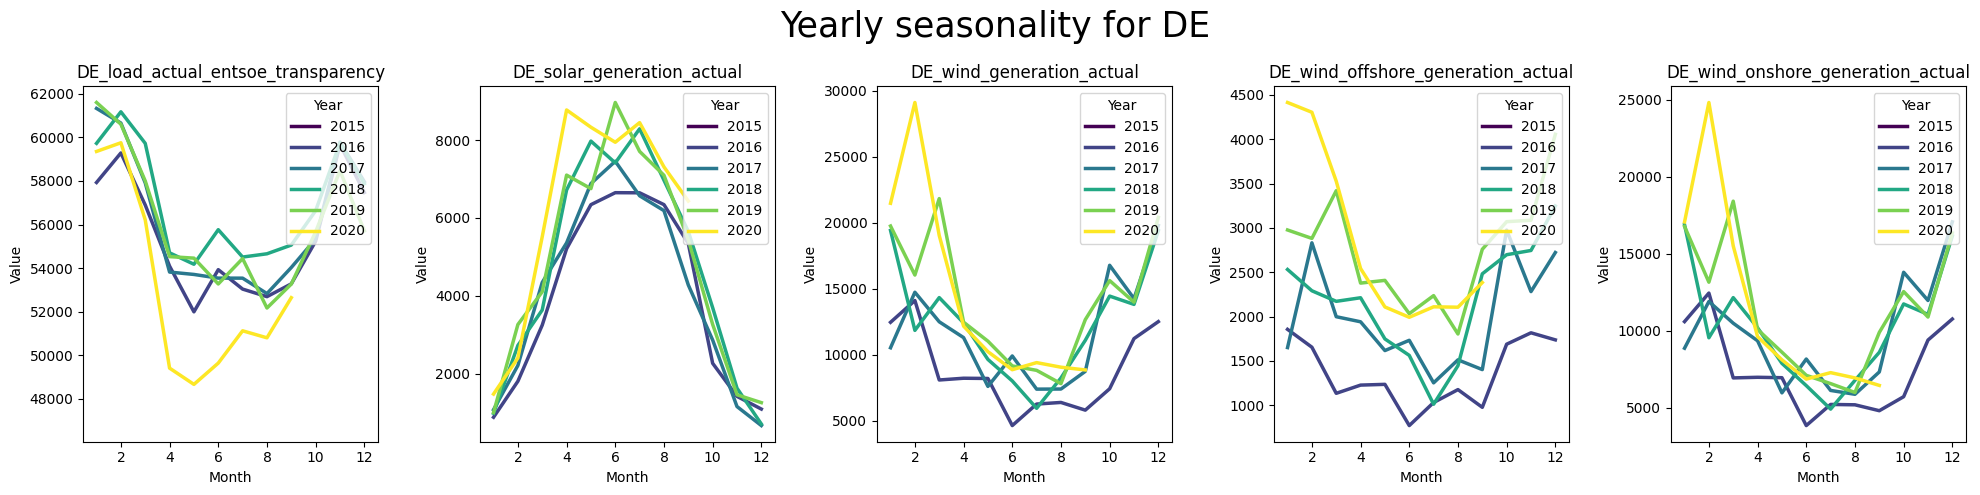

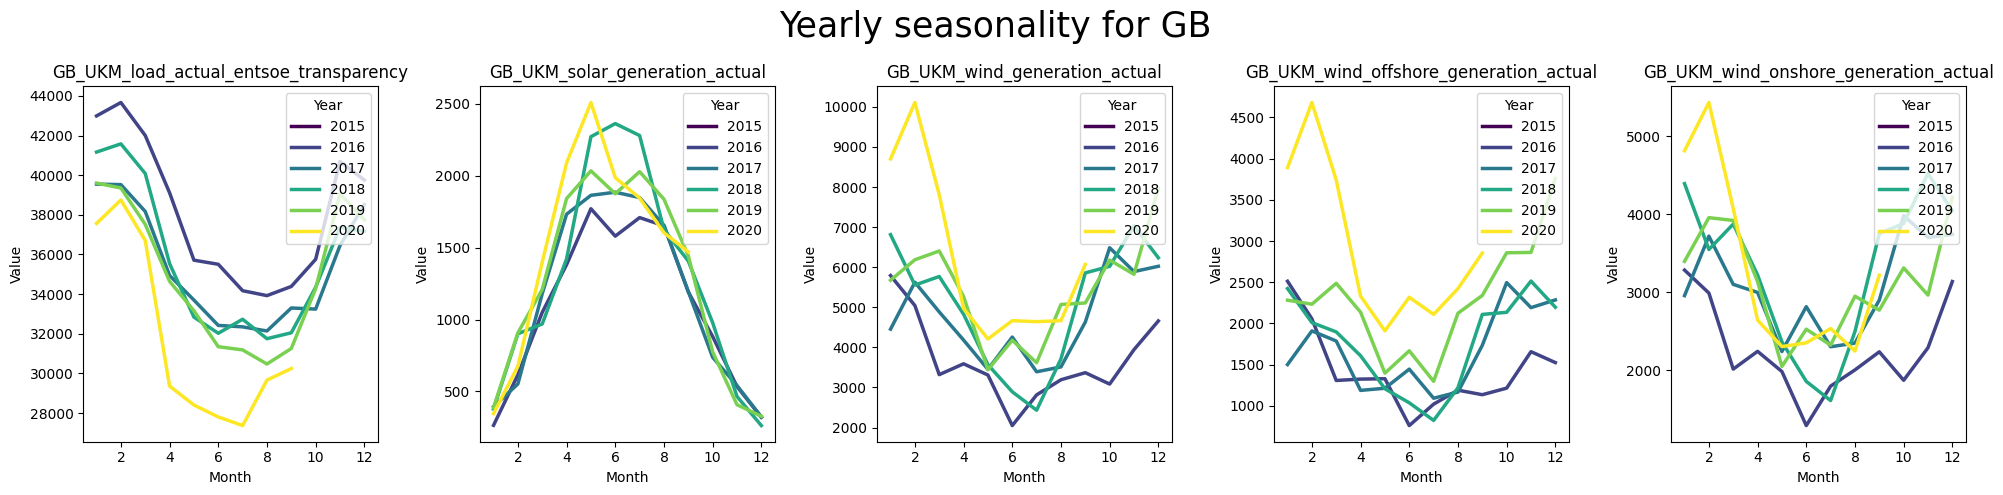

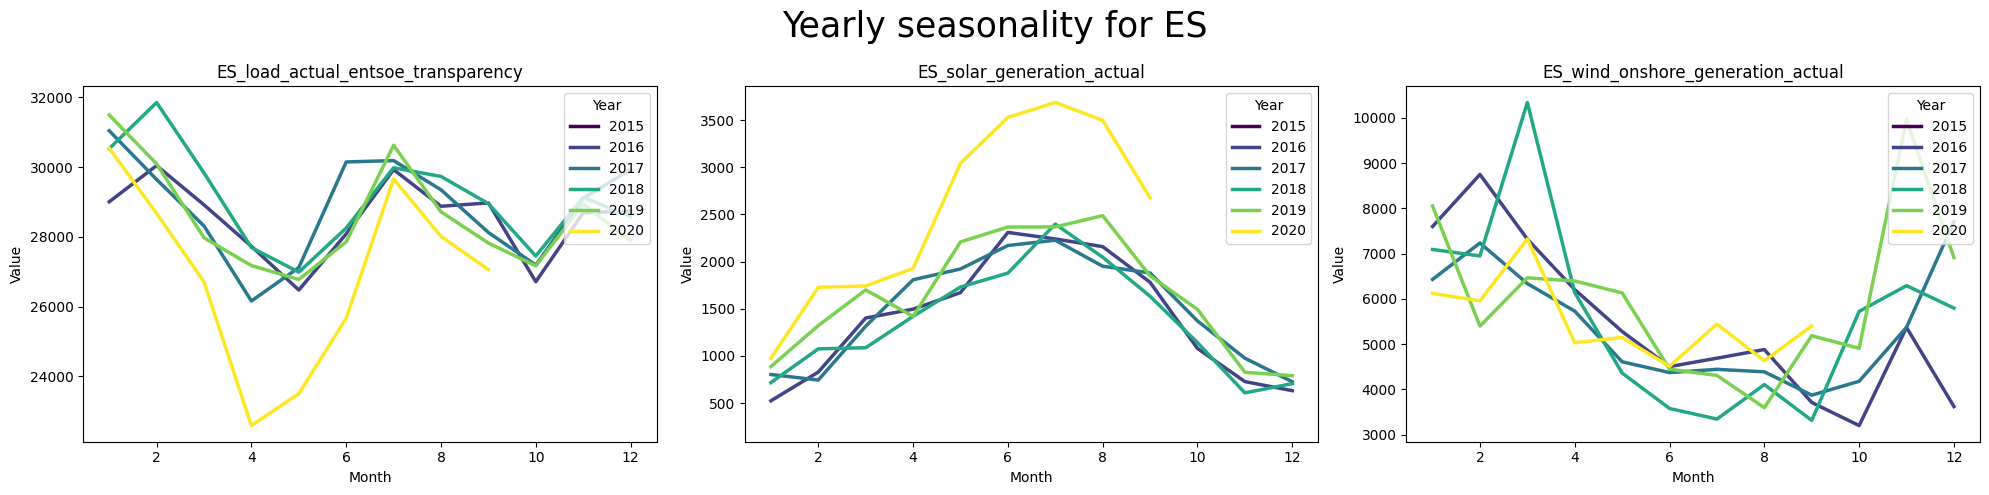

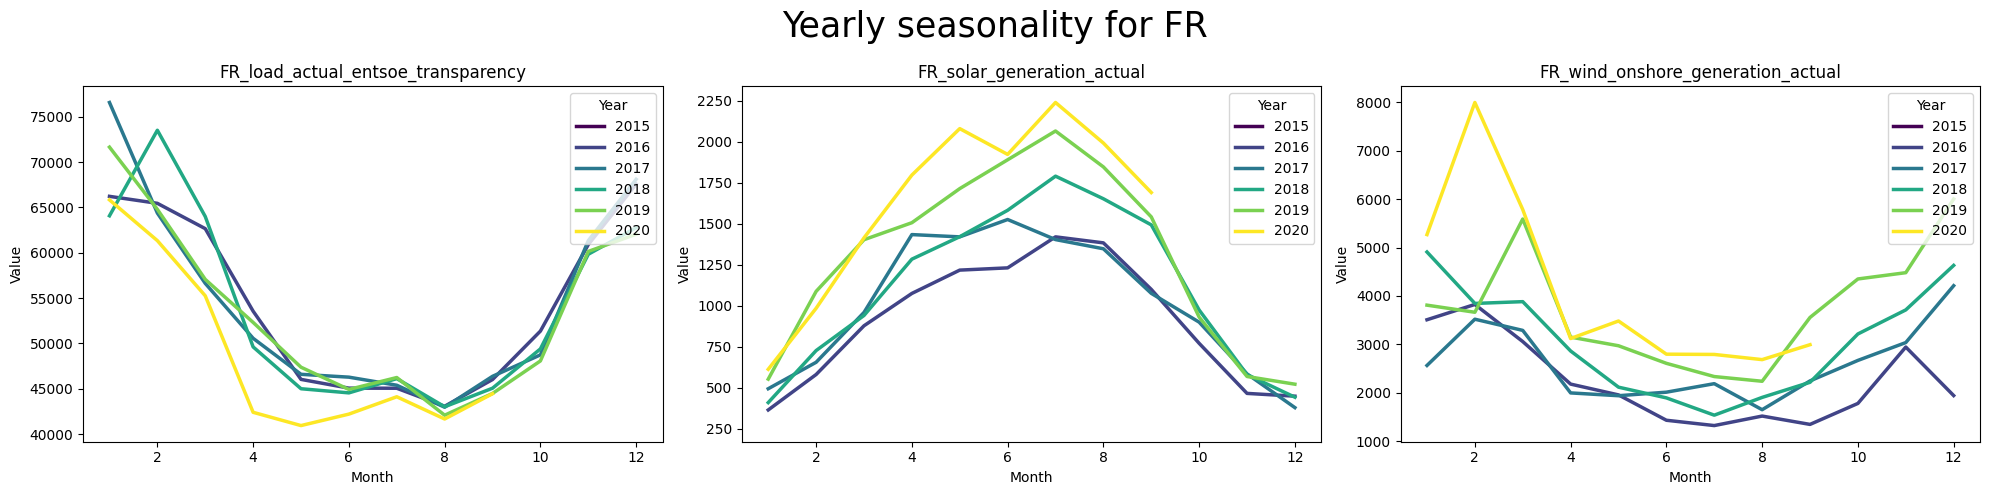

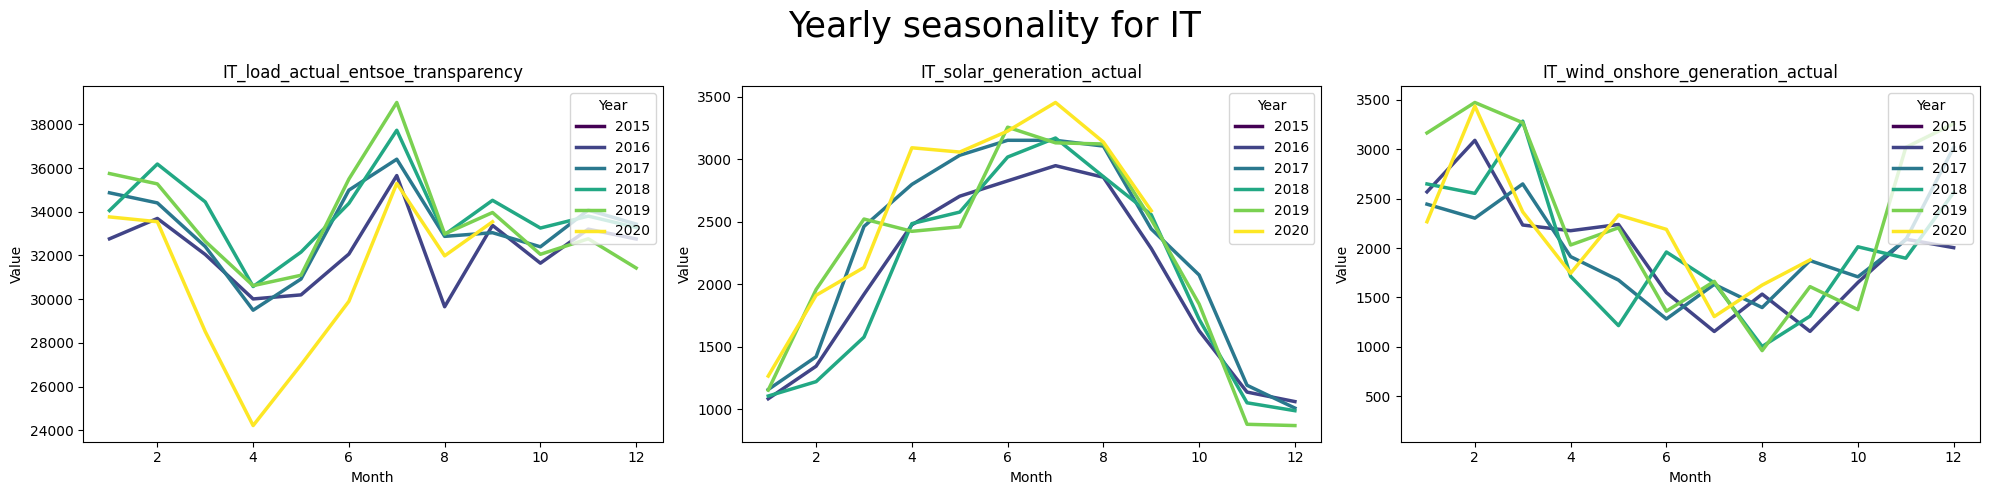

In [7]:
top_5_countries = ['DE', 'GB', 'ES', 'FR', 'IT']

for col in top_5_countries:

    data = df_top_5.filter(like=col, axis=1)

    n_cols = len(data.columns)

    # append cols with date infos
    data = pd.concat([data, df_top_5.iloc[:, -6:]], axis=1)

    plot_seasonality(data = data, 
                     num_cols=n_cols, 
                     title=f'Yearly seasonality for {col}')

Clear daily seasonality of load and solar generation. Therefore, it makes sence to use this parameter in ARIMA model.
Please note that we further will adjust UTC time to real time. The values are shifted 1-2 hours from current UTC time.

Though the different value ranges, we observe the consistency in patterns over all countries for load and solar generation.
The wind generation patterns differ accross all countries.

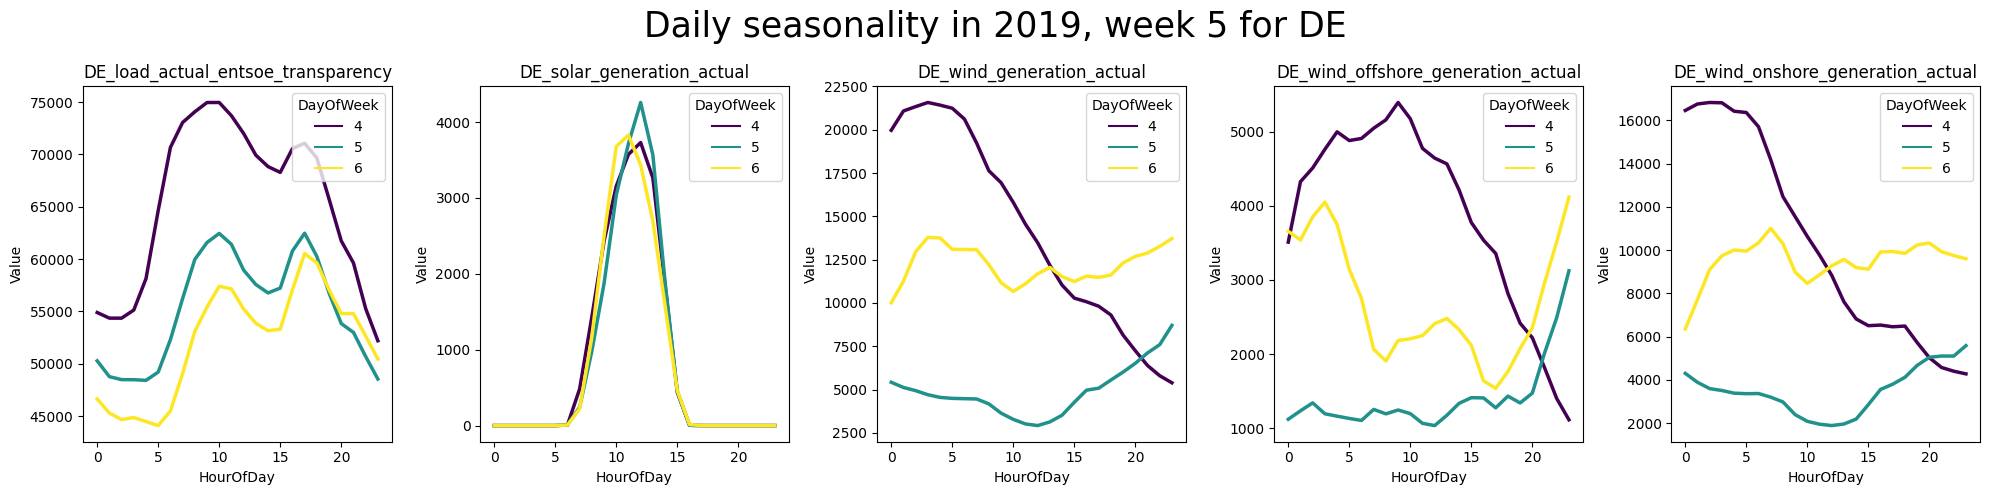

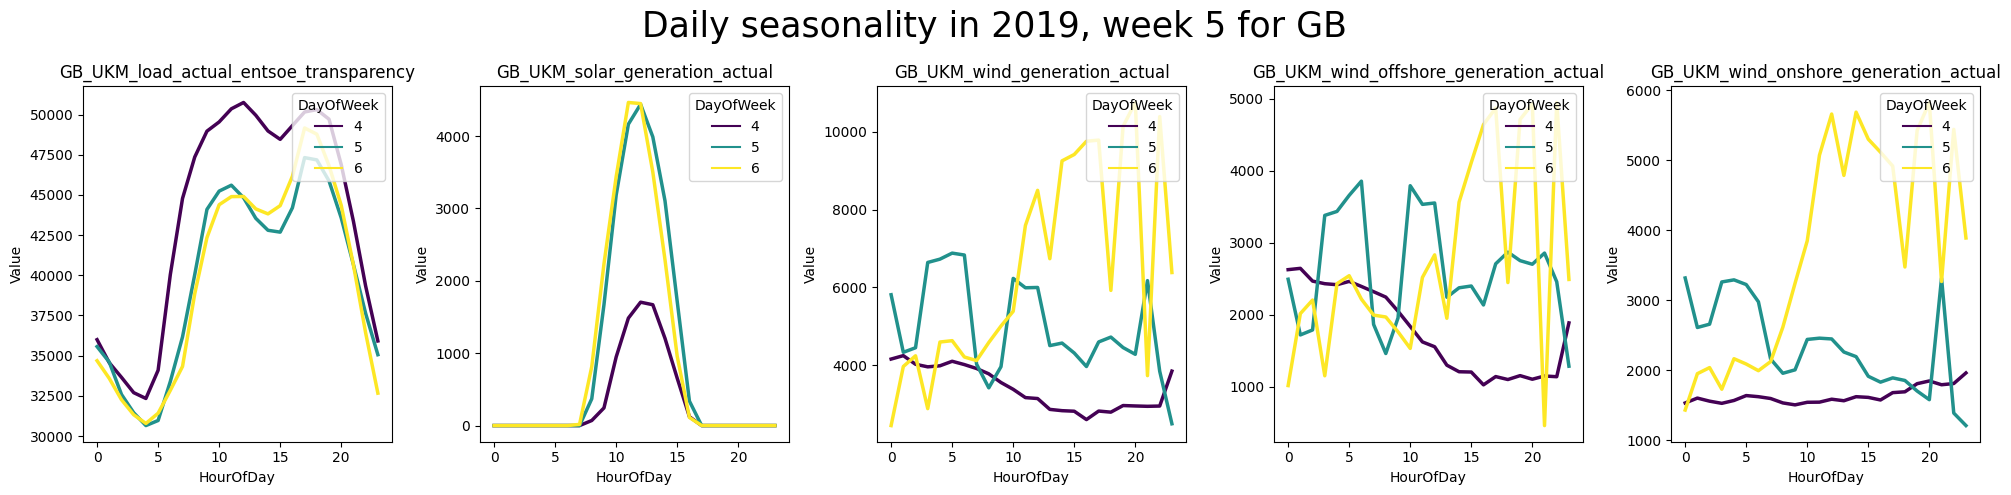

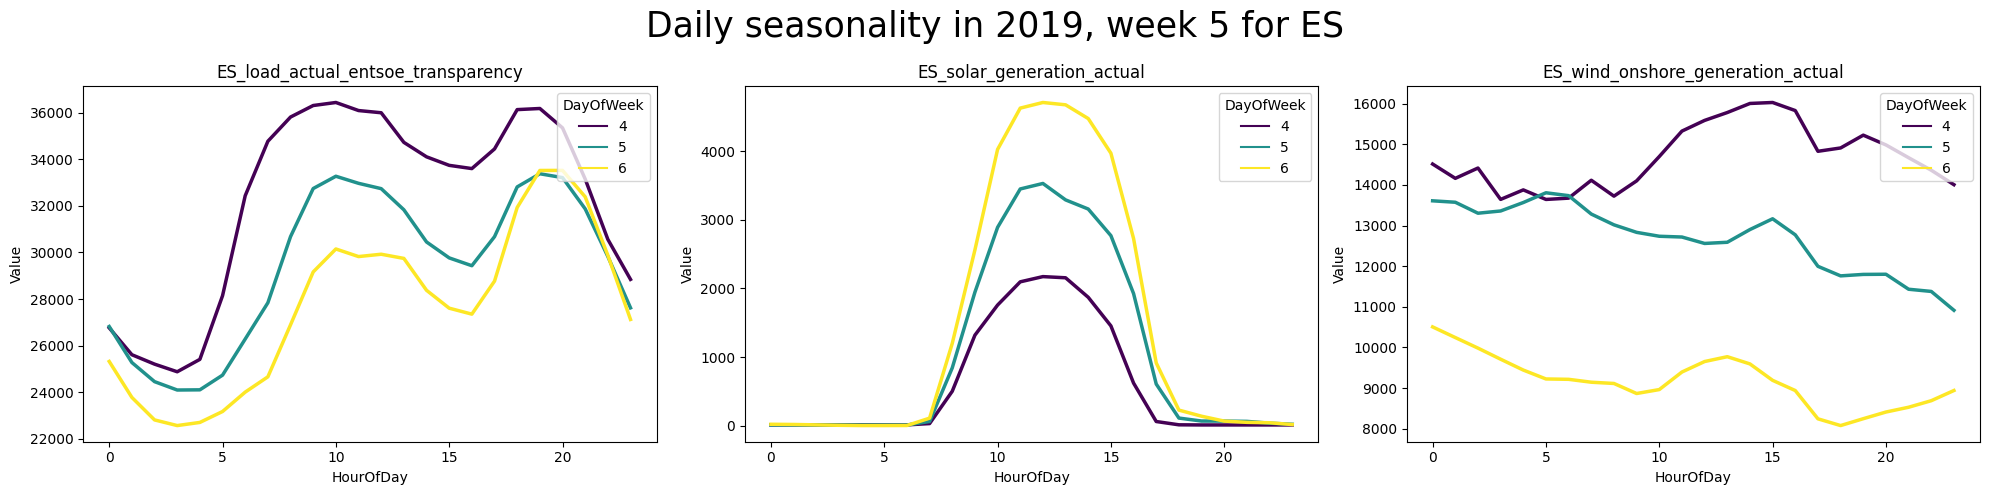

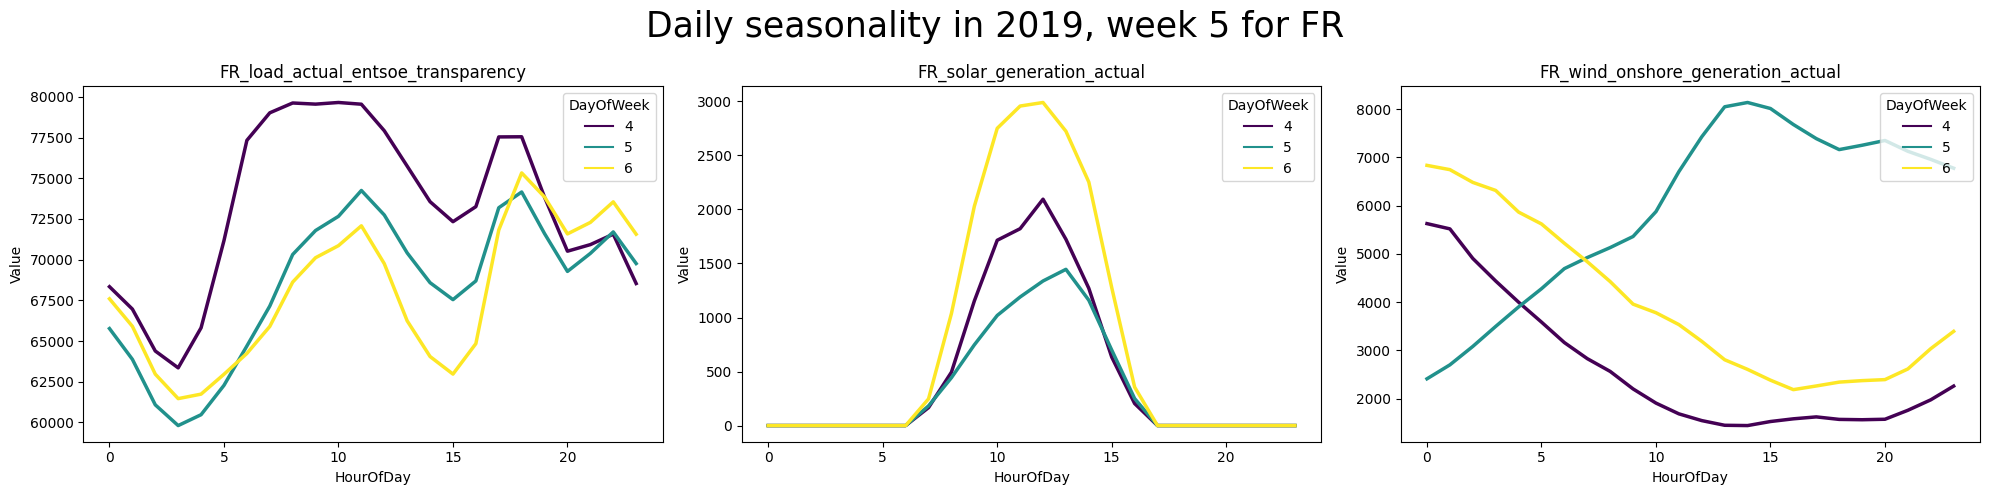

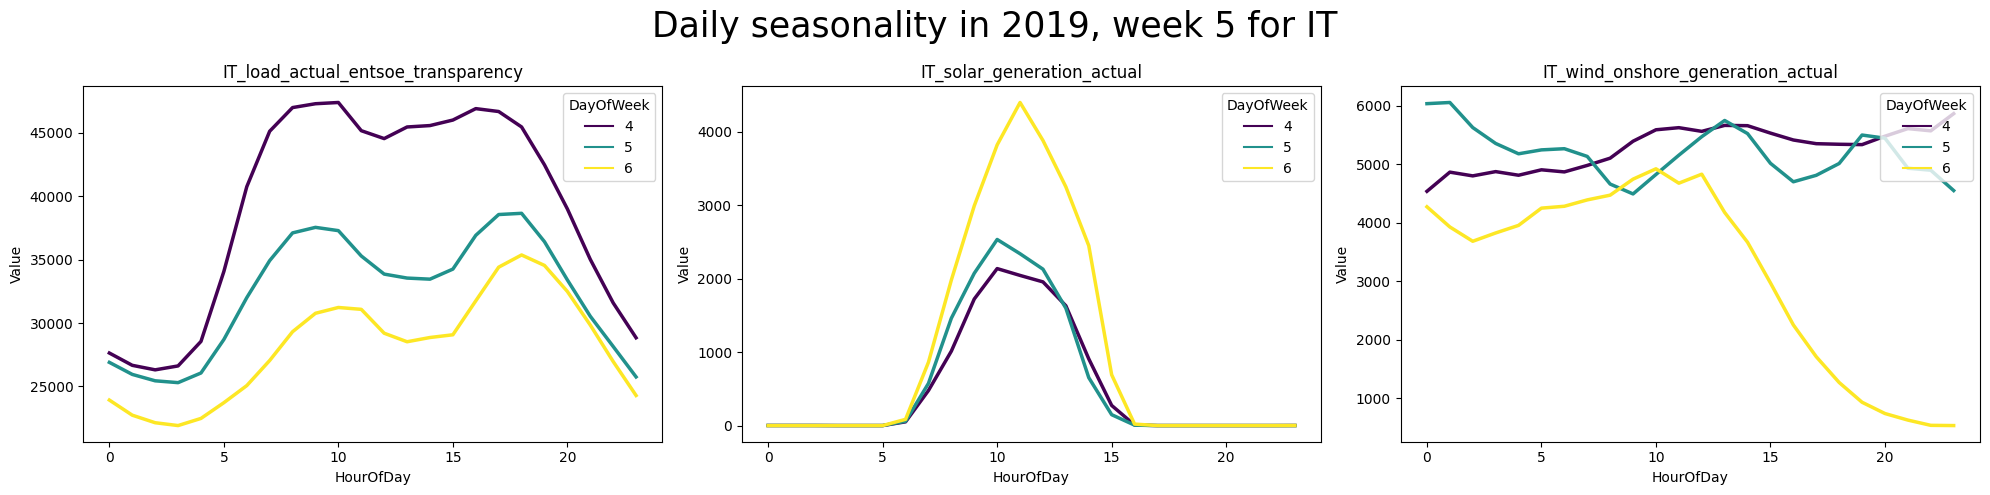

In [45]:
for col in top_5_countries:

    data = df_top_5.filter(like=col, axis=1)

    n_cols = len(data.columns)

    # append cols with date infos
    data = pd.concat([data, df_top_5.iloc[:, -6:]], axis=1)

    plot_seasonality(data=data[(data.index.year==2019) & 
                                (data.index.month==2) & 
                                (data.index.isocalendar().week==5)],
                     frequency='HourOfDay',
                     hue='DayOfWeek',
                     num_cols=n_cols,
                     title = f"Daily seasonality in 2019, week 5 for {col}")

Here are simple line plots of raw time series, which show trends, changes in distributions over years etc.

Examples: 

We can clearly see here that load in Germany, Spain; solar generation in Spain - have different distributions in 2020 which is our potential test set.

Wind generation in Germany, France, Britain; solar generation in France - increasing trend.

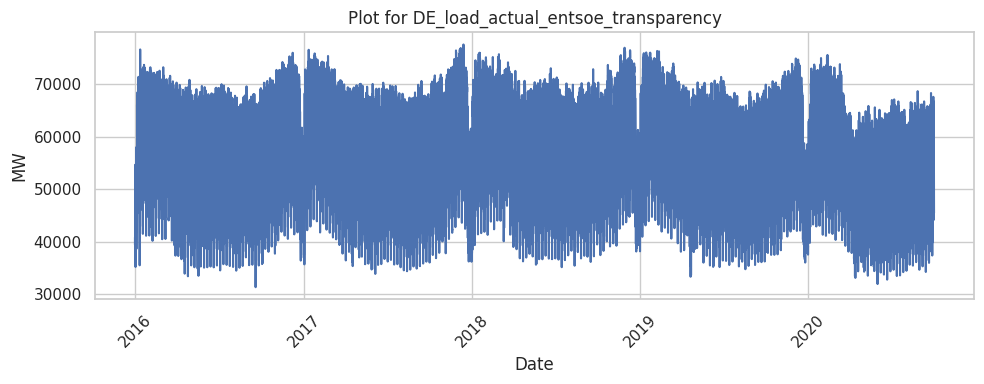

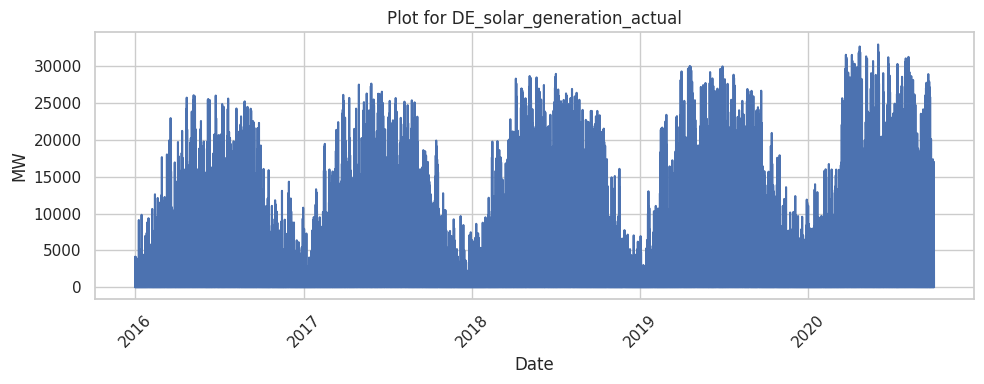

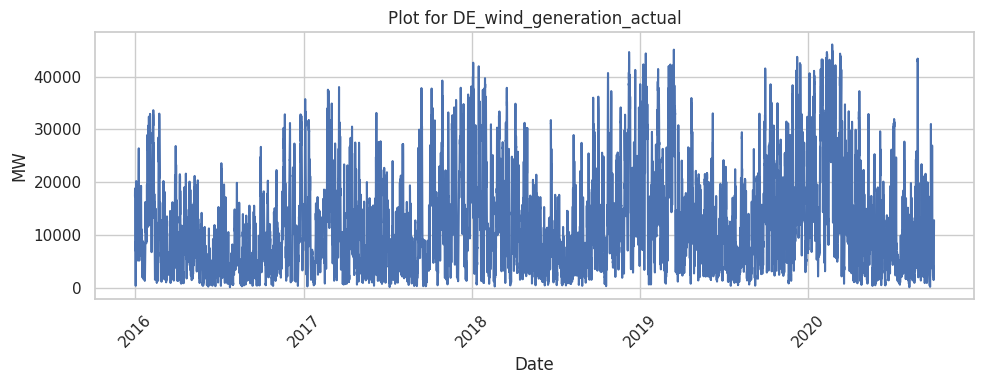

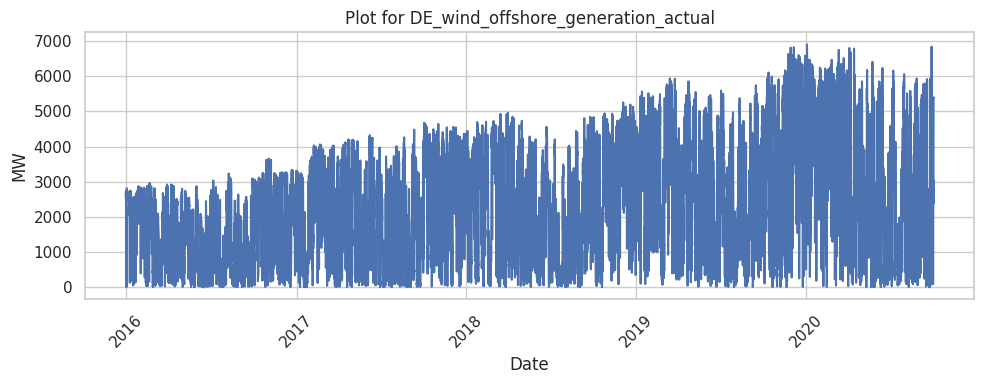

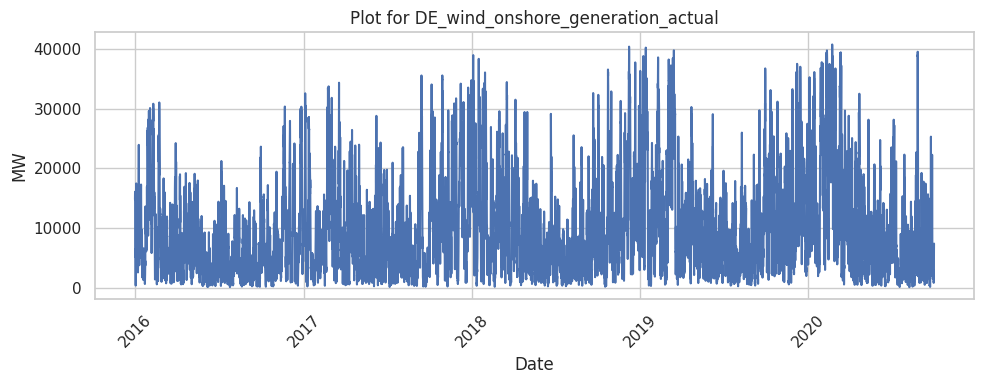

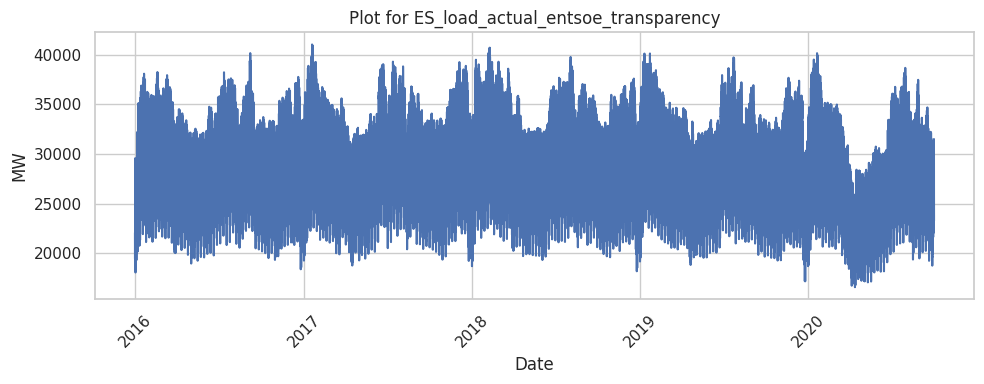

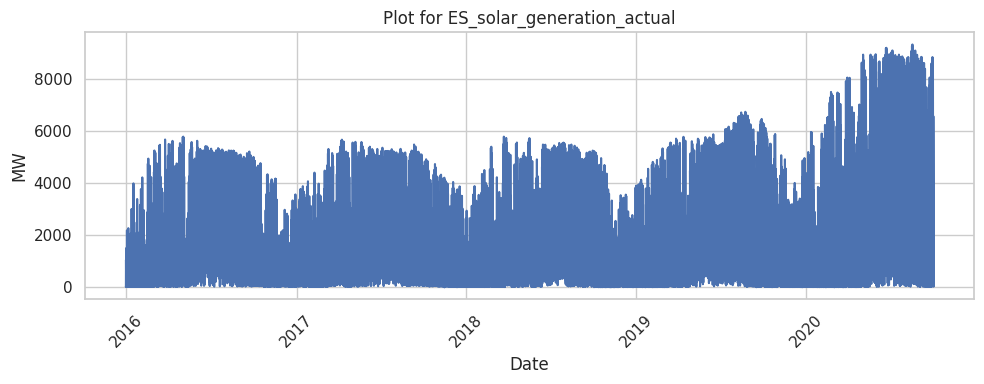

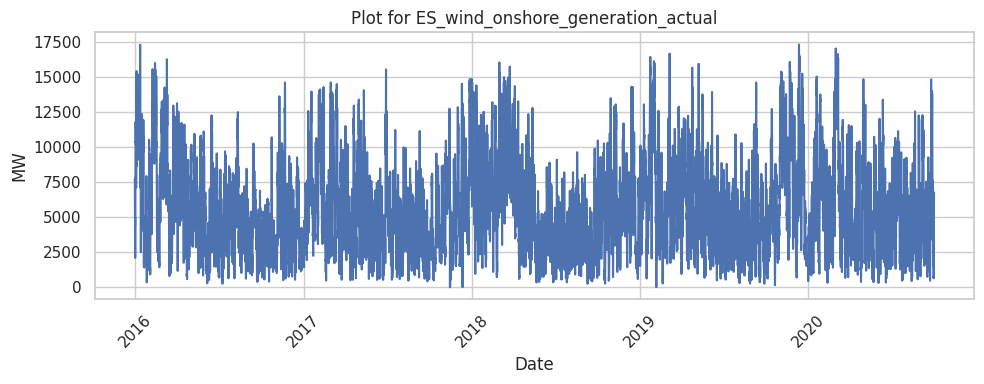

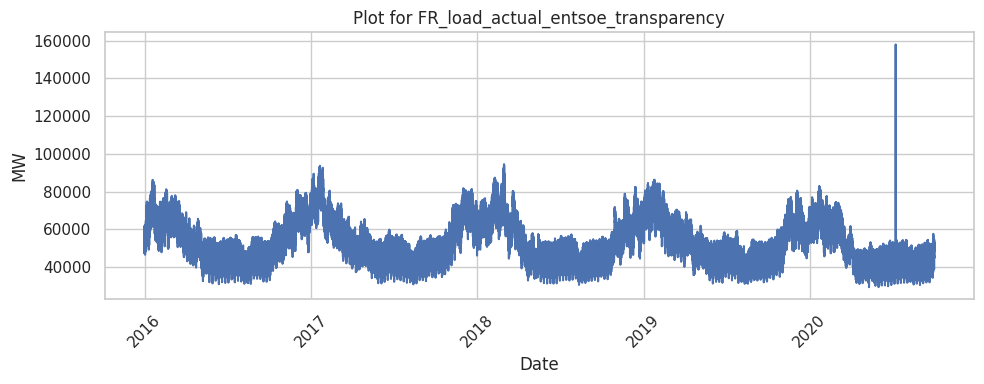

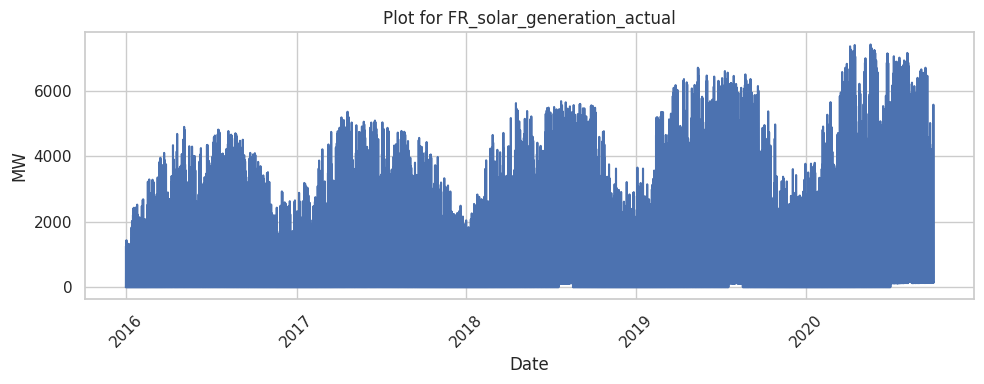

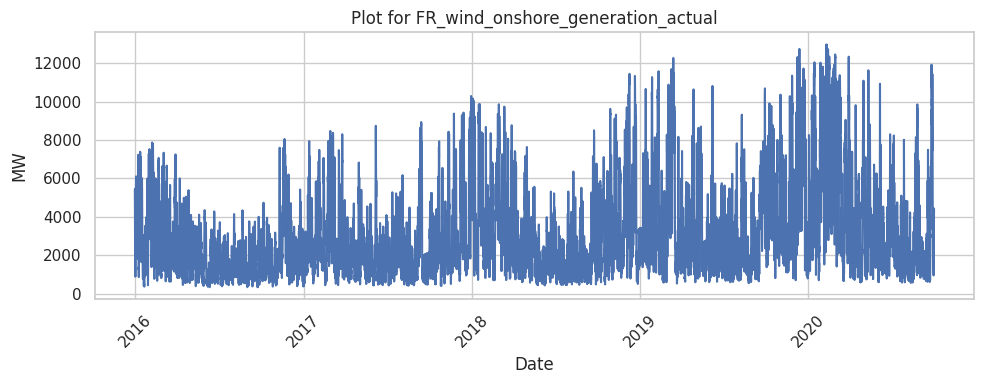

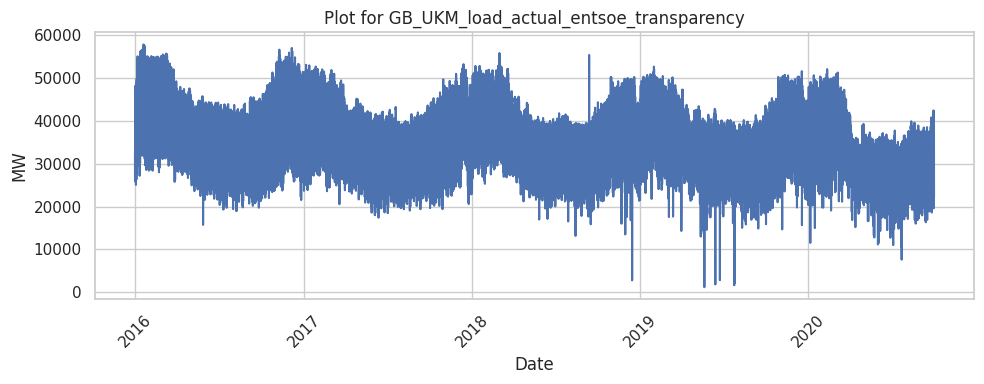

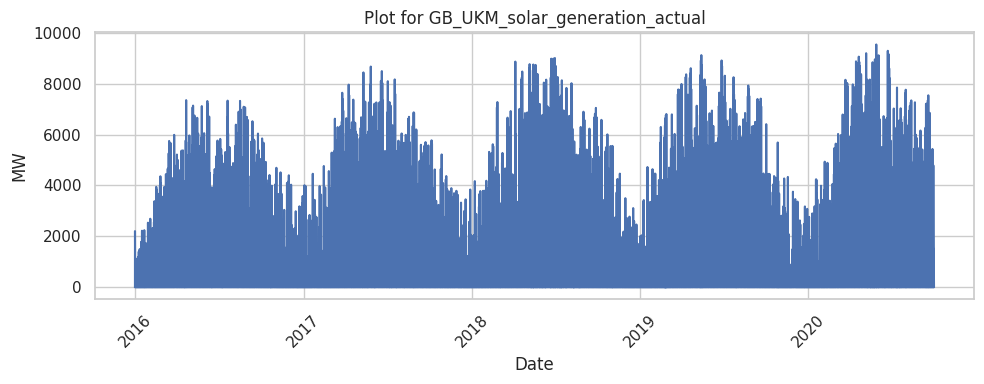

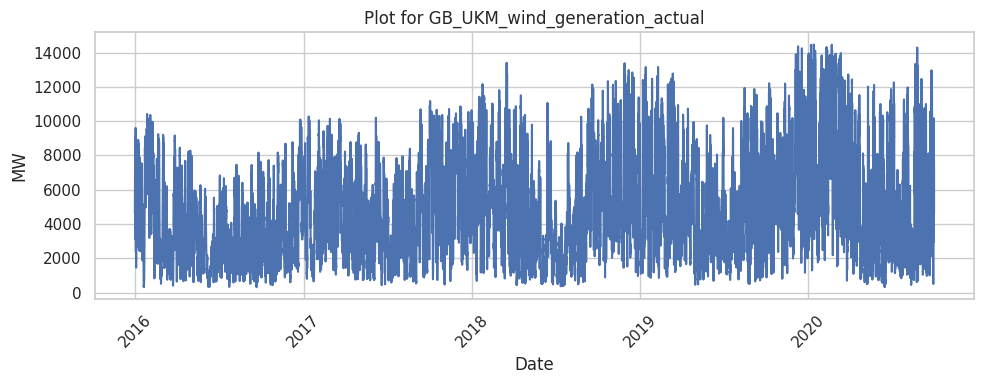

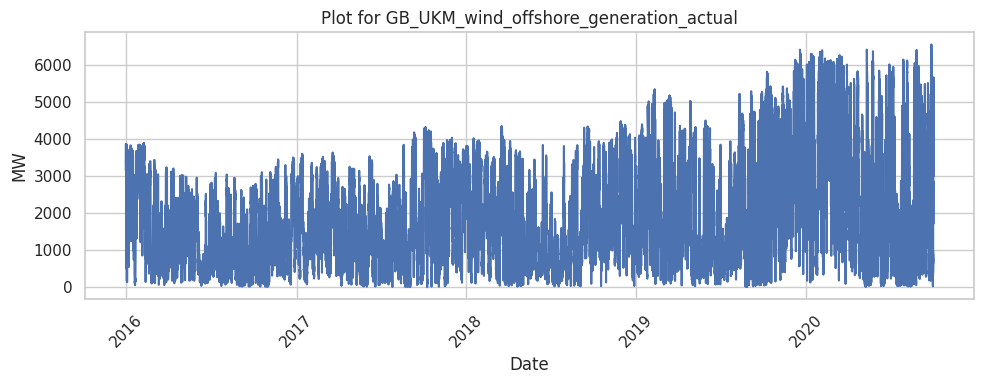

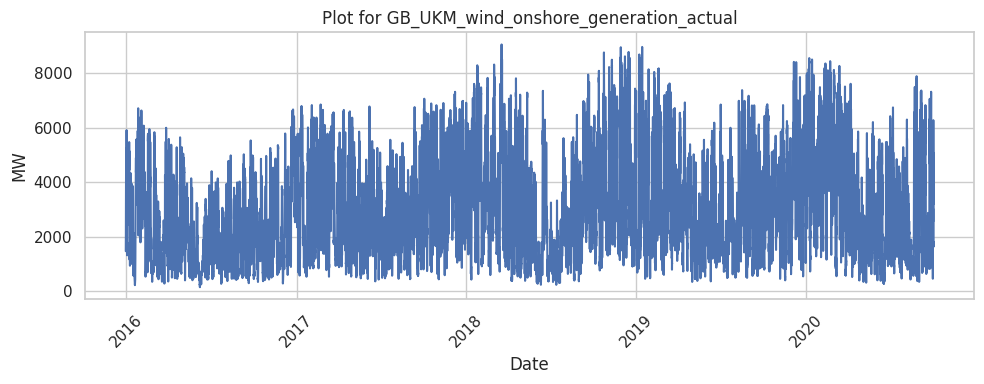

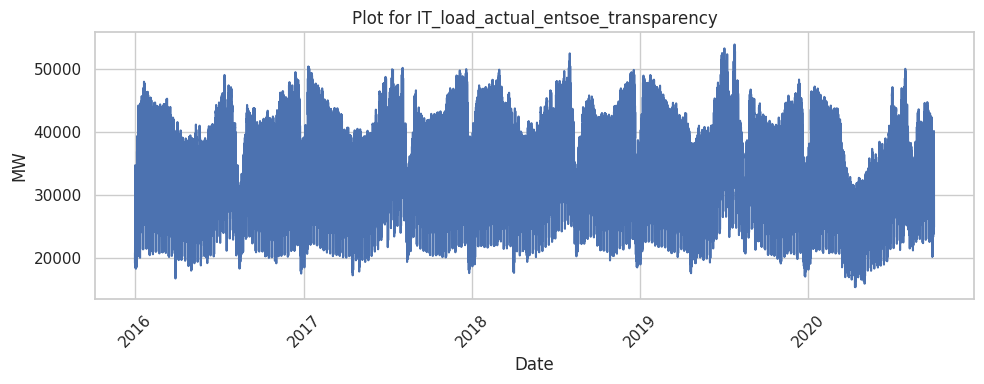

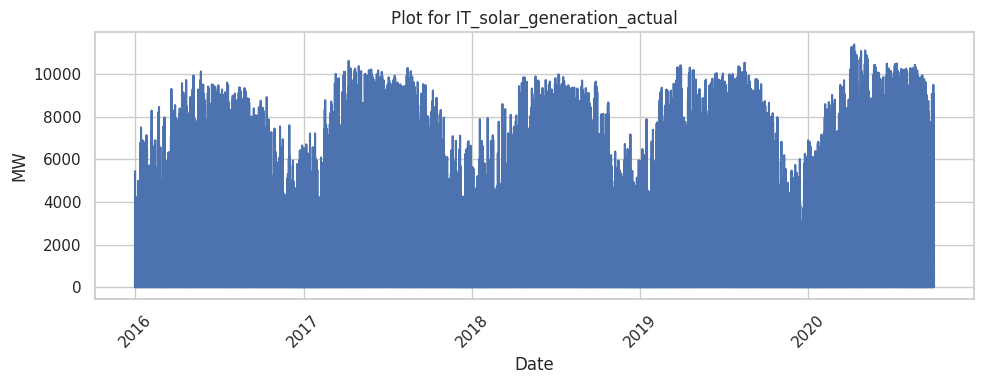

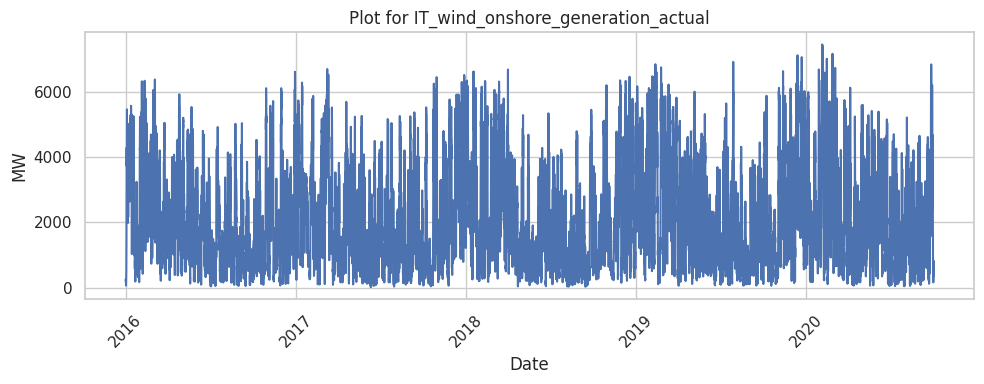

In [13]:
sns.set(style="whitegrid")

# Create line plots for each column
for col in df_top_5.columns[:-6]: 
    plt.figure(figsize=(10, 4))  
    sns.lineplot(data=df_top_5, x='date', y=col) 
    plt.title(f'Plot for {col}')  
    plt.xlabel('Date')  
    plt.ylabel('MW')  
    plt.xticks(rotation=45)  
    plt.tight_layout()  
    plt.show()  

# 2. Distribution

Here we have plots for values in each column. 

The data is not normally distributed. Some variables are skewed, such as "FR_wind_onshore_generation_actual" and "IT_wind_onshore_generation_actual". And others have multimodal distributions, as "DE_load_actual_entsoe_transparency" and "IT_load_actual_entsoe_transparency".

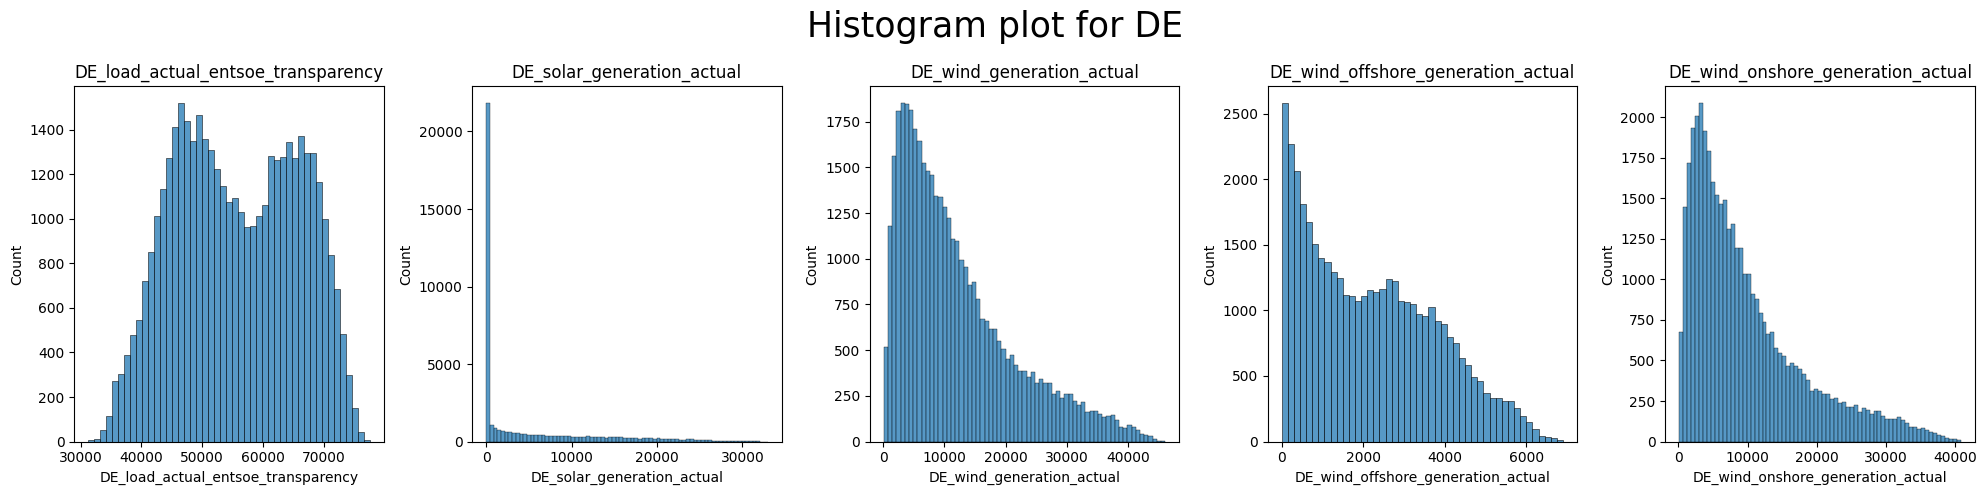

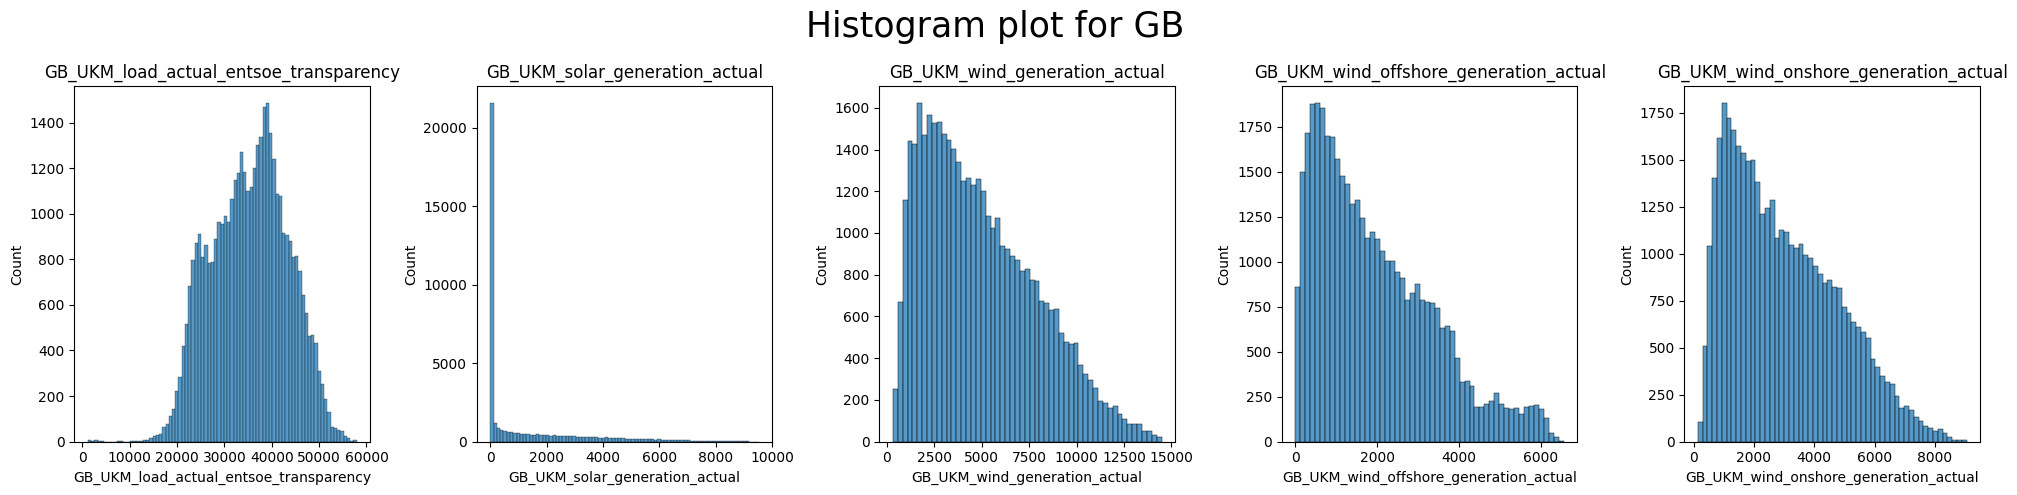

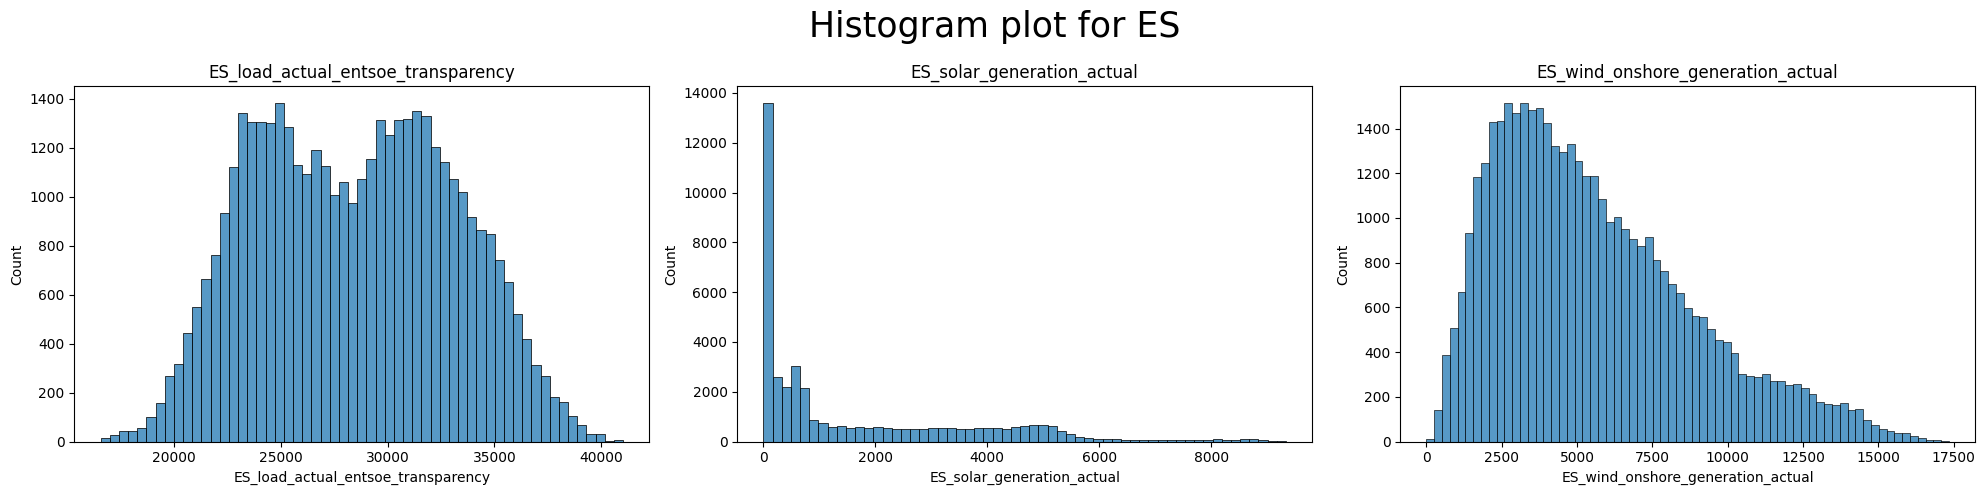

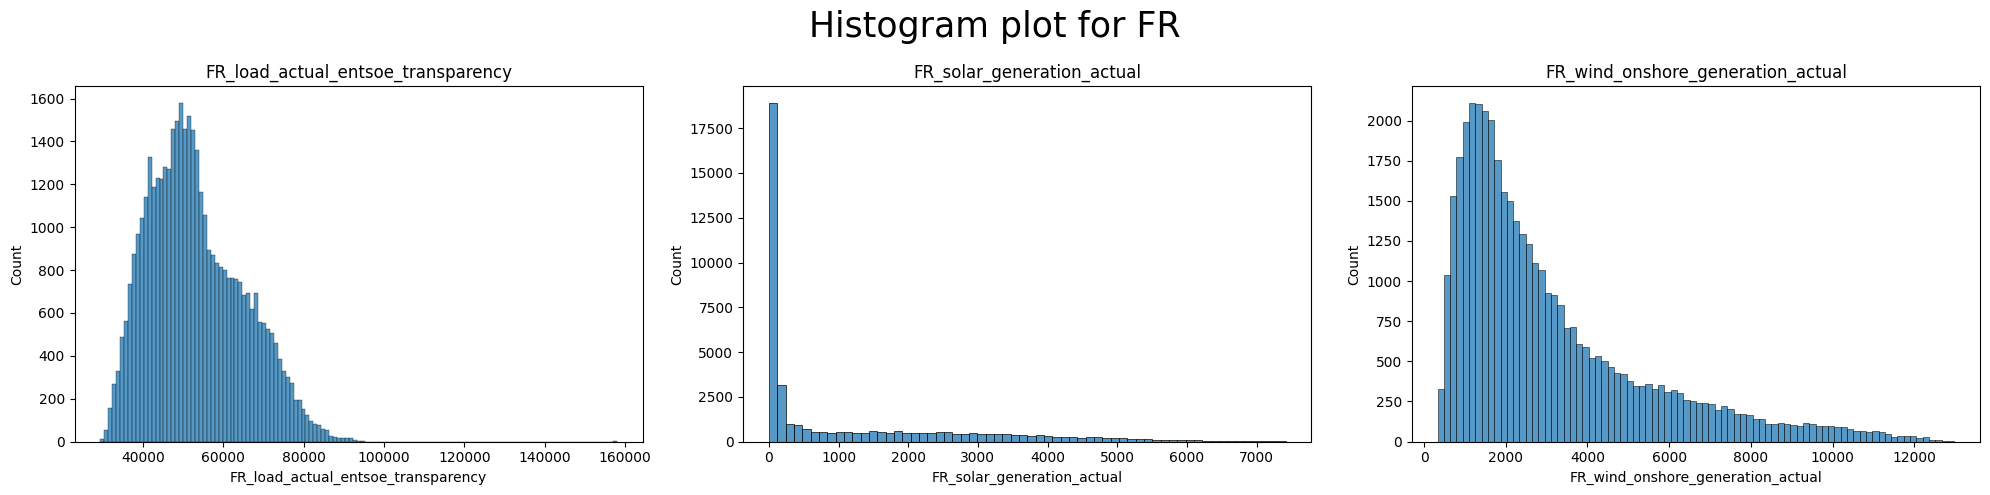

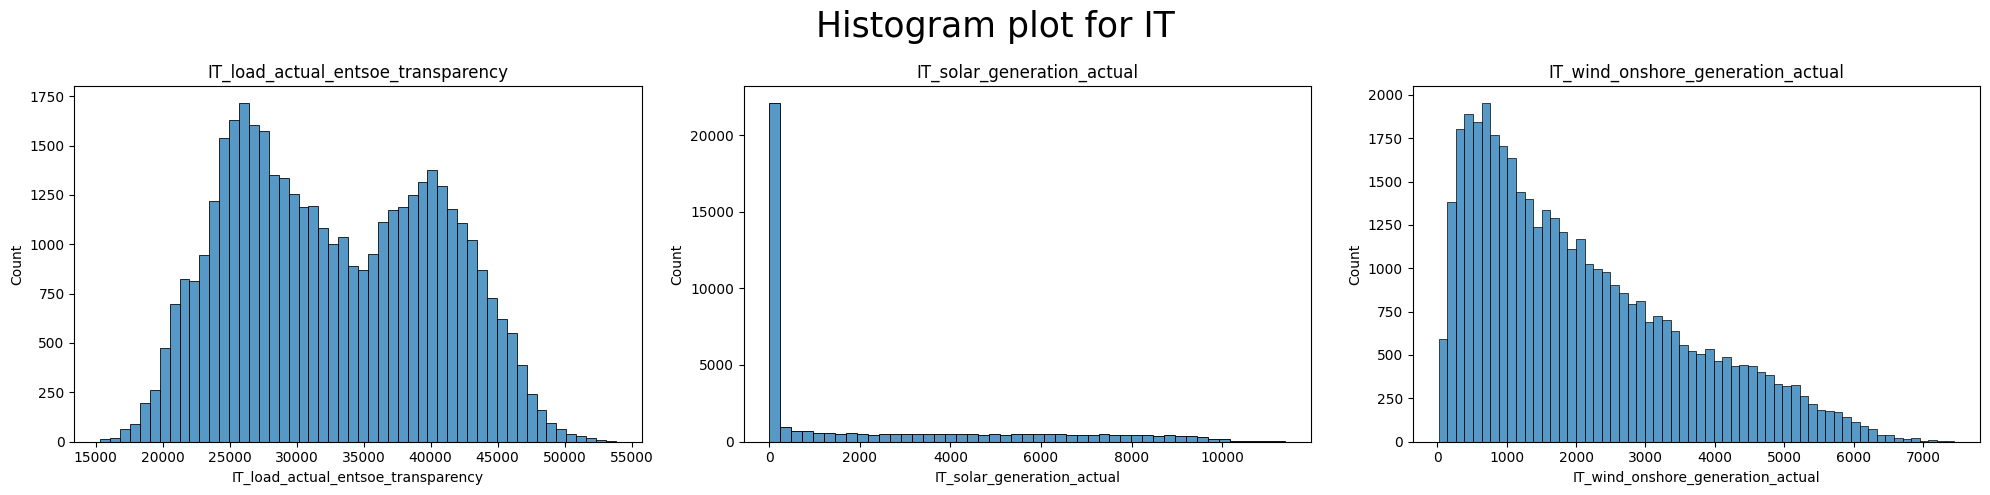

In [47]:
for col in top_5_countries: 

    data = df_top_5.filter(like=col, axis=1)

    n_cols = len(data.columns)
    
    hist_plots(data = data, col=col, num_cols=n_cols,
               title = f"Histogram plot for {col}")

# 3. Correlation

Correlation between features.

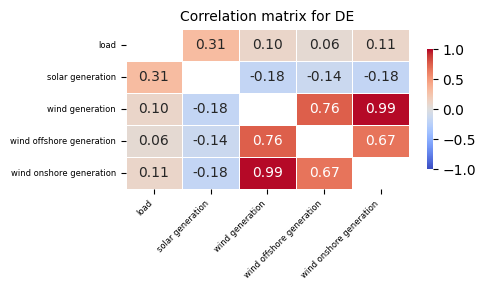

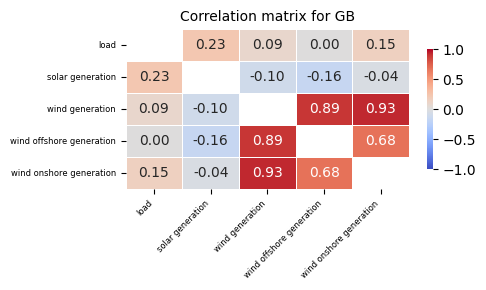

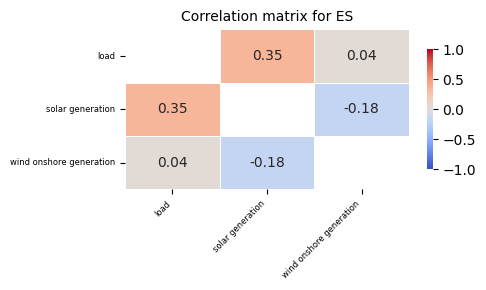

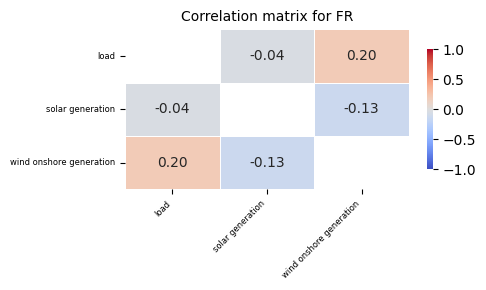

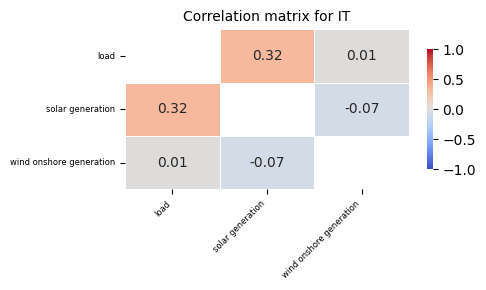

In [48]:
for country in top_5_countries:

    data = df_top_5.filter(like=country, axis=1)
    
    corr_plot(data = data,
              title = f"Correlation matrix for {country}")

# 4. Periodogram

While performing seasonality check using MSTL, I noticed that it always fit your time series to all seasonalities you predefine. So, I proved it by fitting 45 degree line on e. g. daily, yearly etc seasonalities and MSTL found them! (see Seasonality_proof.ipynb)

Therefore we try to determine most important frequencies with periodogram (source: [Tensorflow Tutorial](https://www.tensorflow.org/tutorials/structured_data/time_series)).

The most meaningful spikes are daily signals for all columns, except wind.

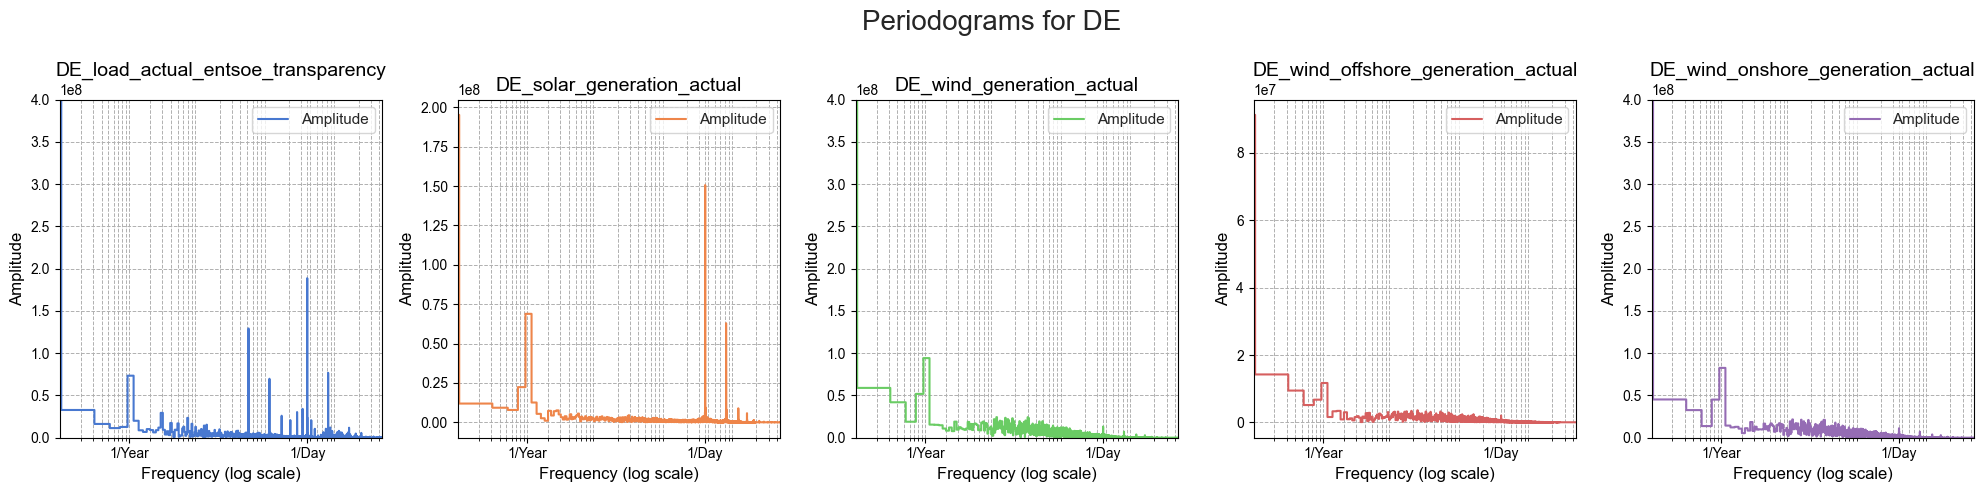

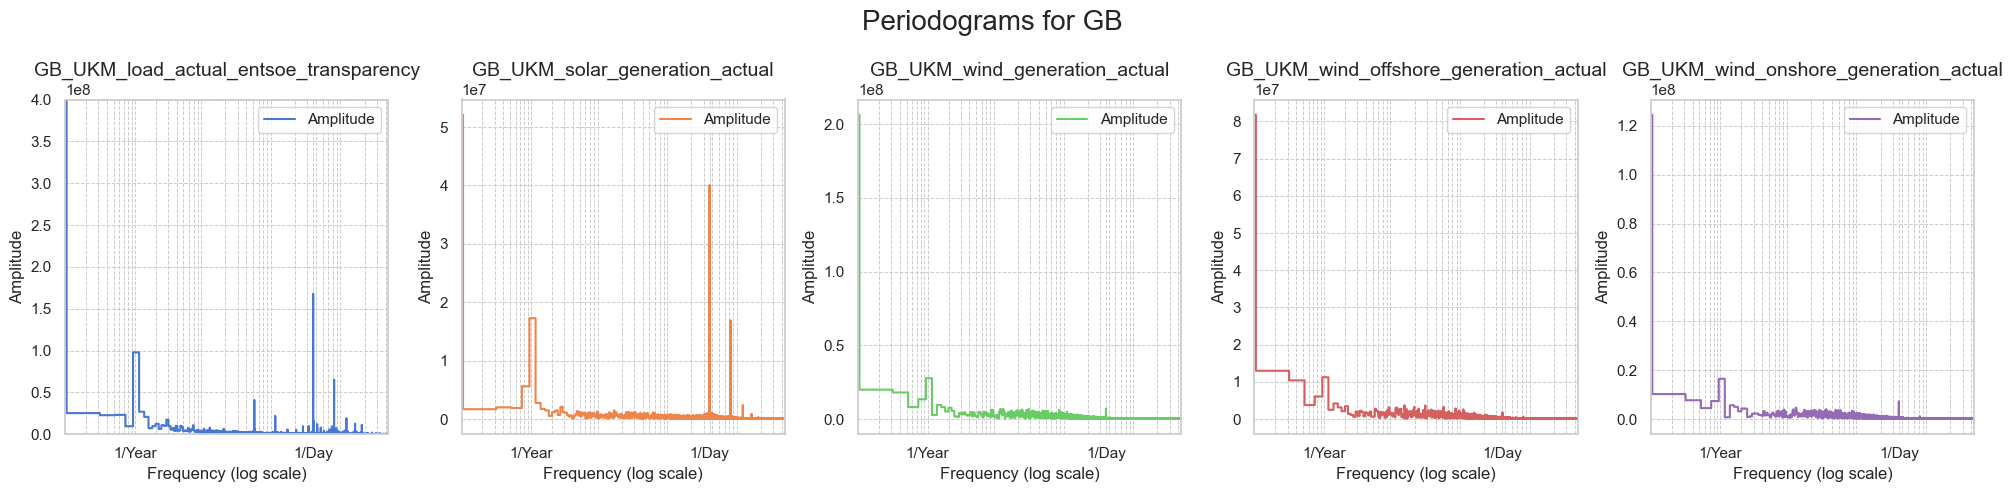

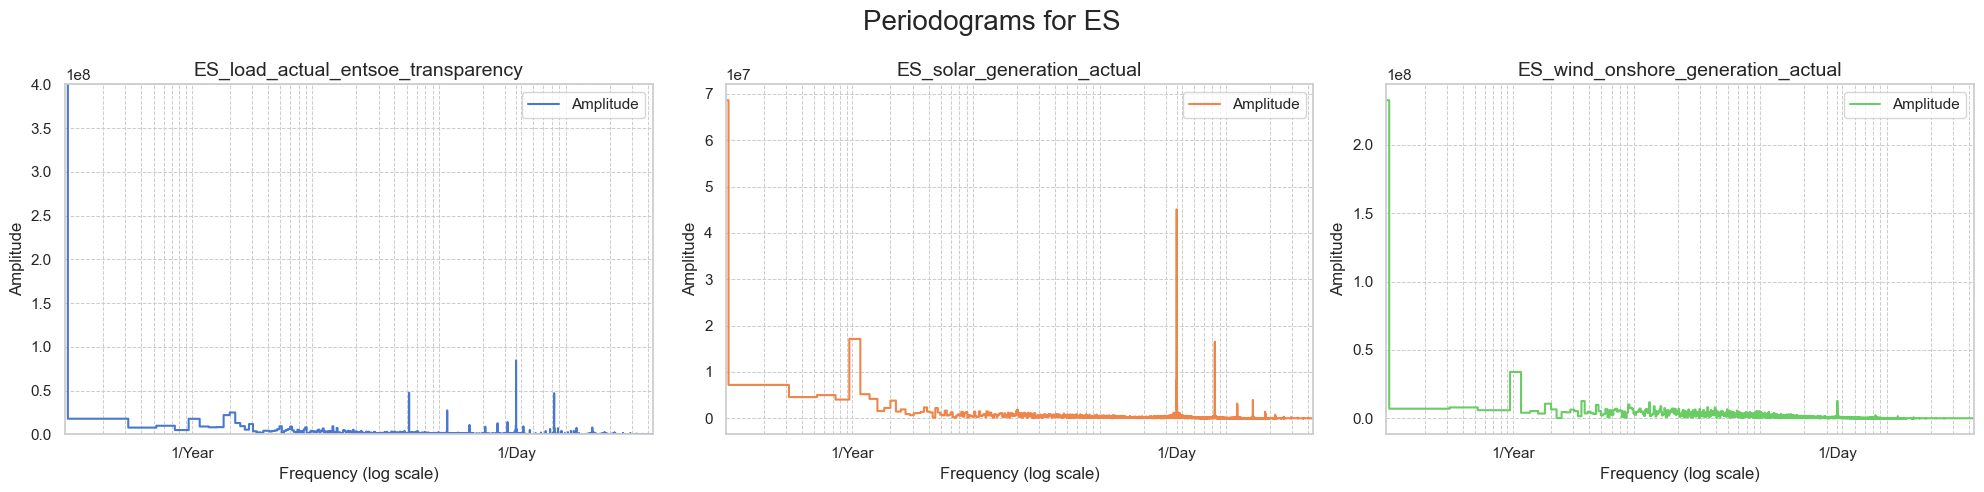

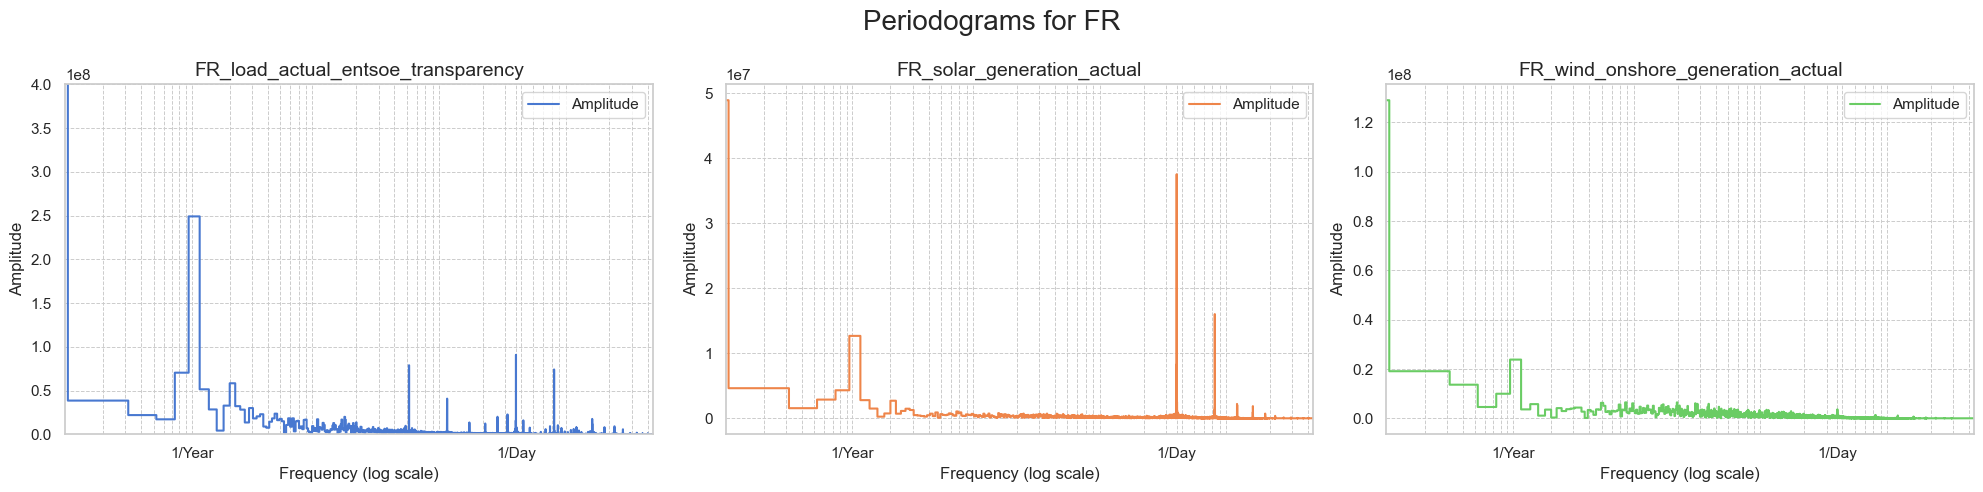

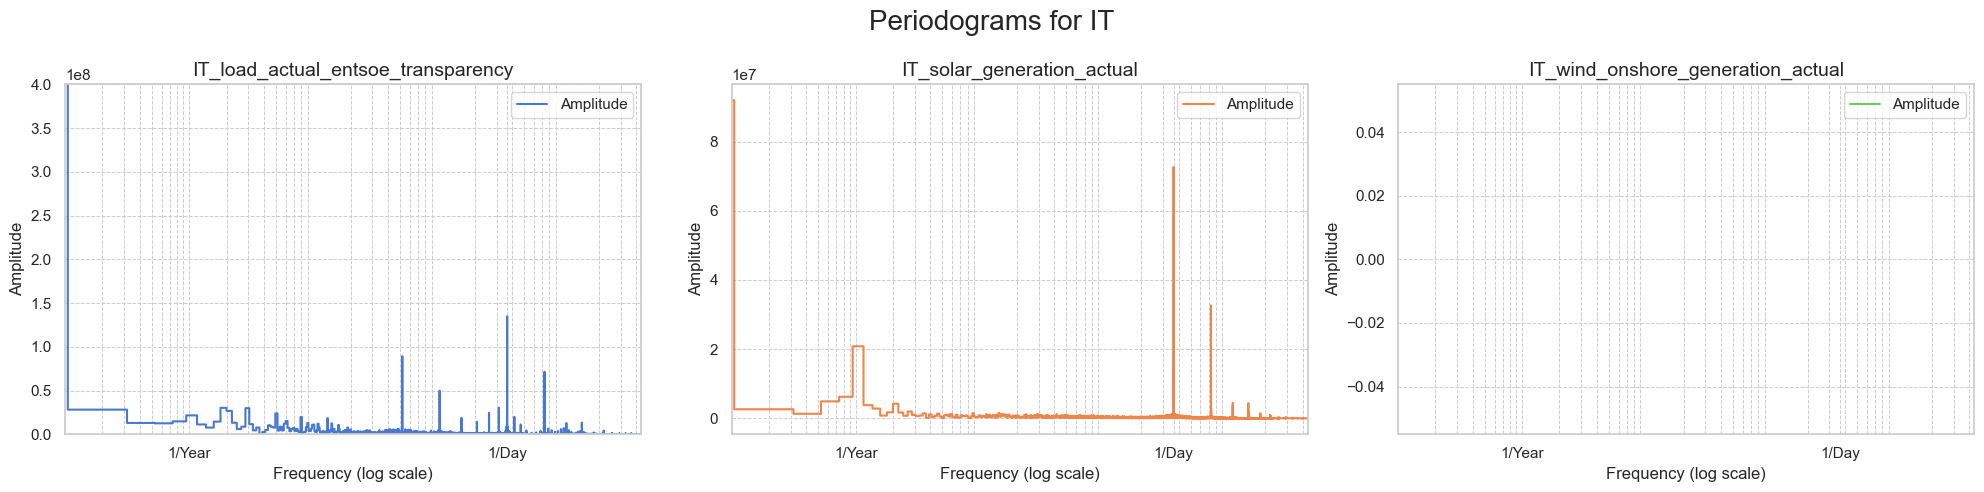

In [57]:
for col in top_5_countries:

    data = df_top_5.filter(like=col, axis=1)

    n_cols = len(data.columns)

    # Plot periodograms
    periodograms(data=data, 
                 num_cols=n_cols, 
                 title=f'Periodograms for {col}')

# 5. Heatmap

Shows the average values of each column between hours and months.


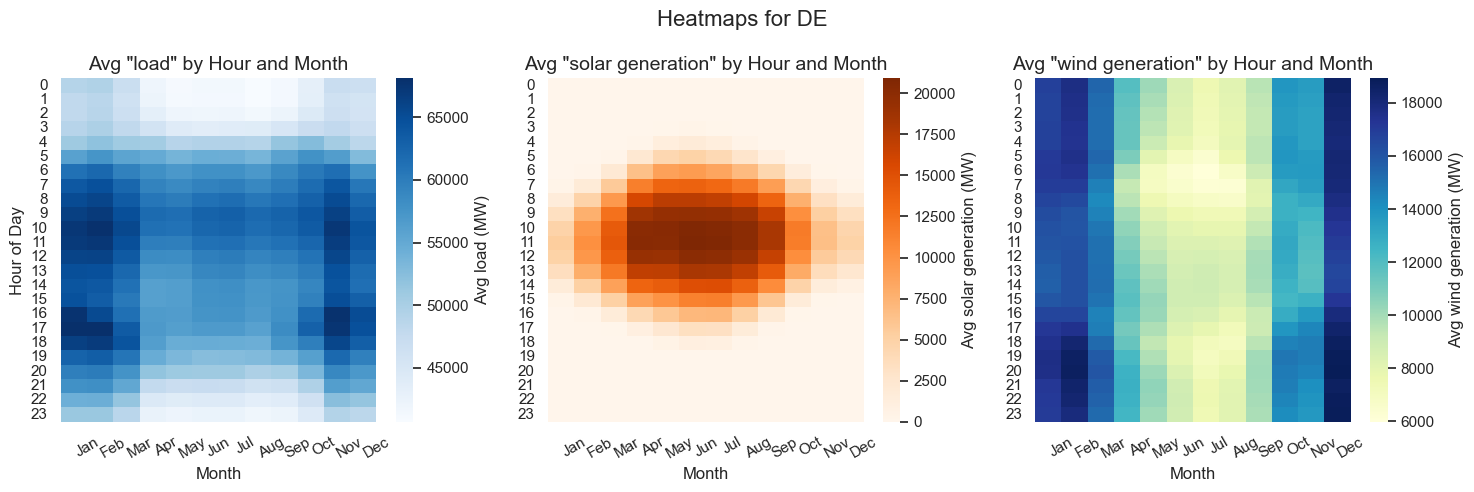

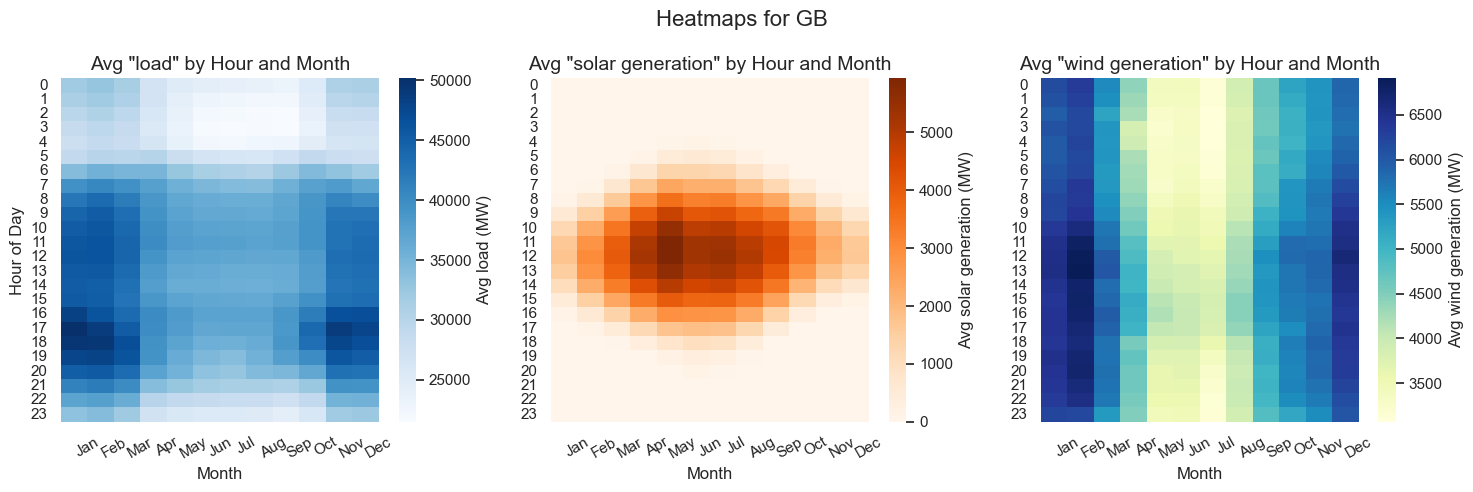

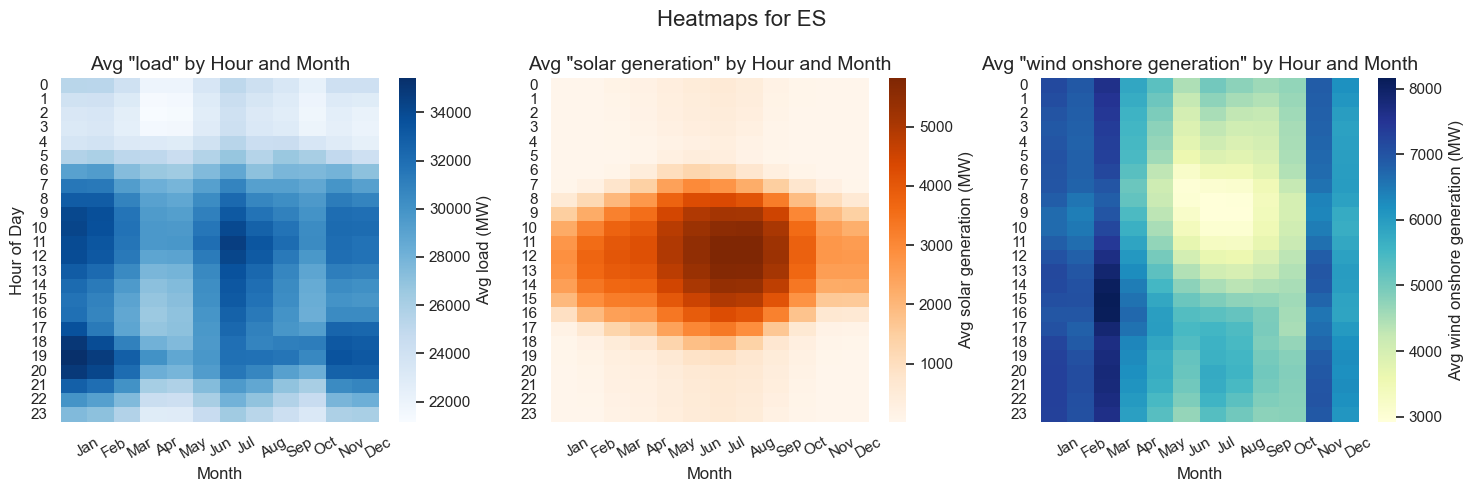

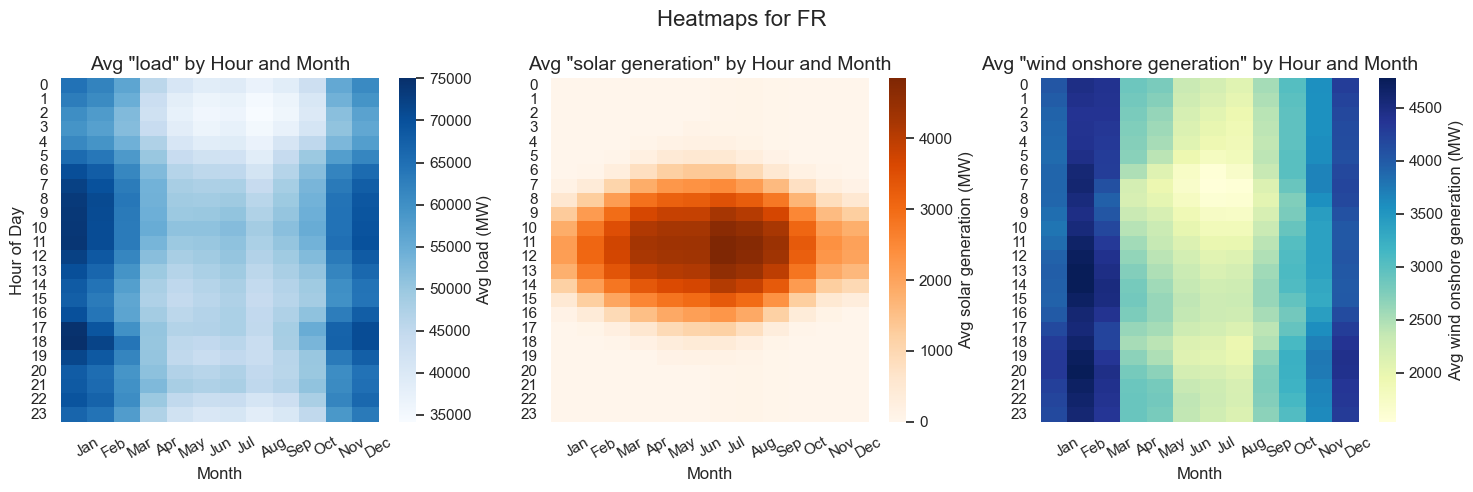

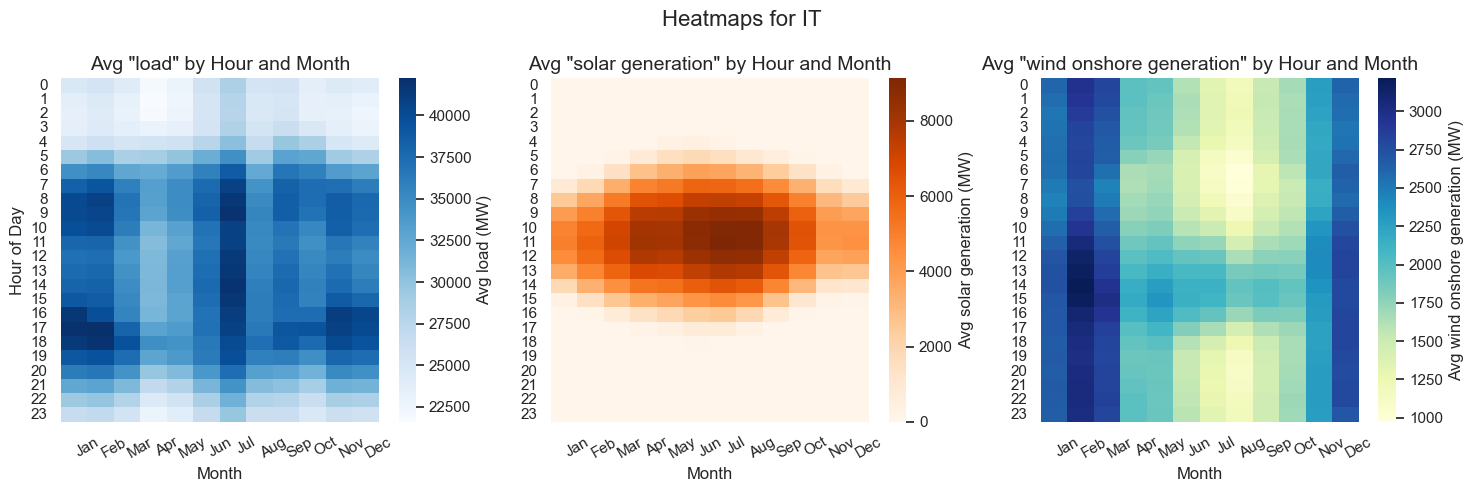

In [58]:
for country in top_5_countries:

    data = df_top_5.filter(like=country, axis=1)
    
    heatmap_plot(data=data.iloc[:, :3], country=country)

# 6. Barplot per season

Plot dependencies between variables over seasons: e. g. Winter -> high avg load and low avg solar, in Summer is reverse dependency.

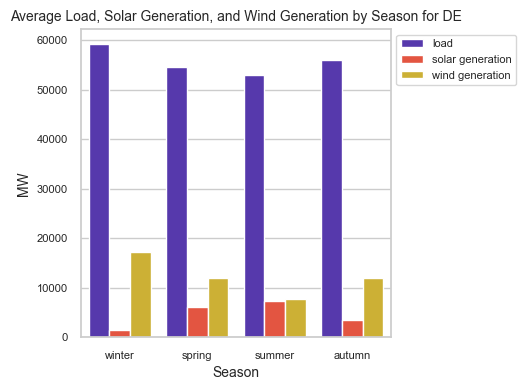

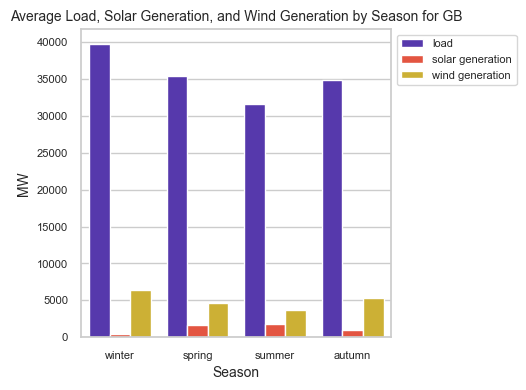

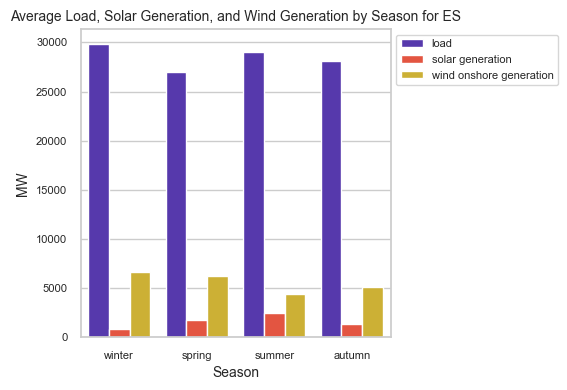

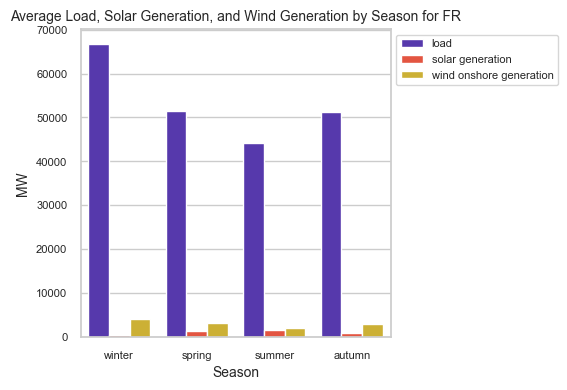

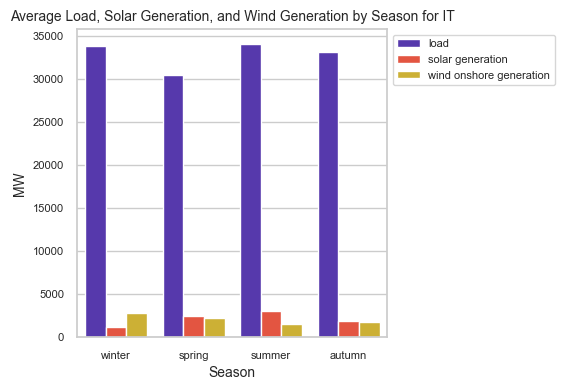

In [59]:
for country in top_5_countries:

    data = df_top_5.filter(like=country, axis=1)
    
    
    stacked_bar_plot_per_season(data.iloc[:, :3], country=country)

# 7. Correlations with time lags 

Are there some important lags in one variable that can help to explain the other variable? (linear dependency) As we can see there is an important negative lag, where load is low and solar generation high -> that means that when it is sunny outside people usually work at the office and do not use home appliances (TV, washing machine, etc.), or are outside at weekend. And reverse.

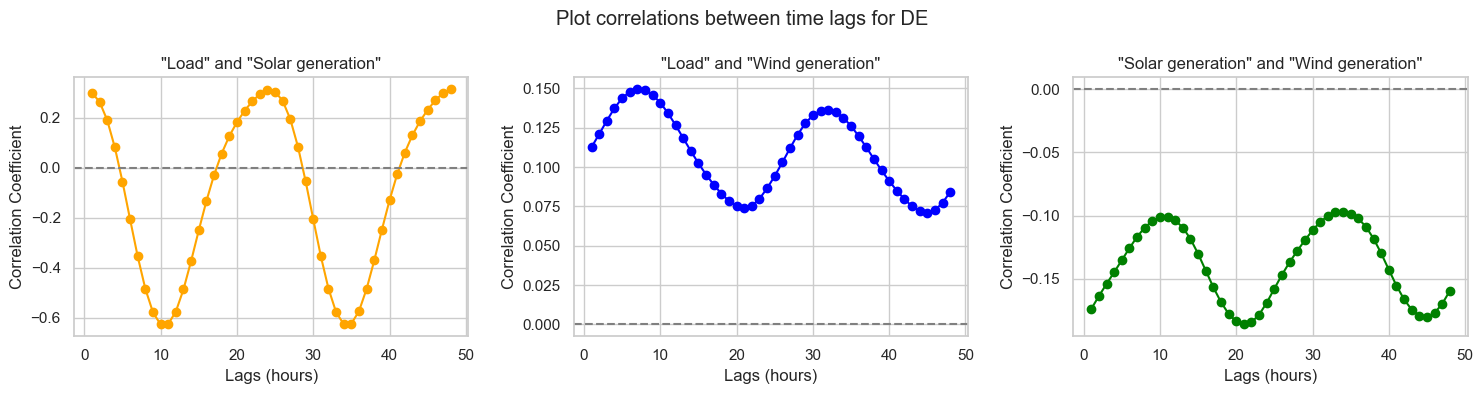

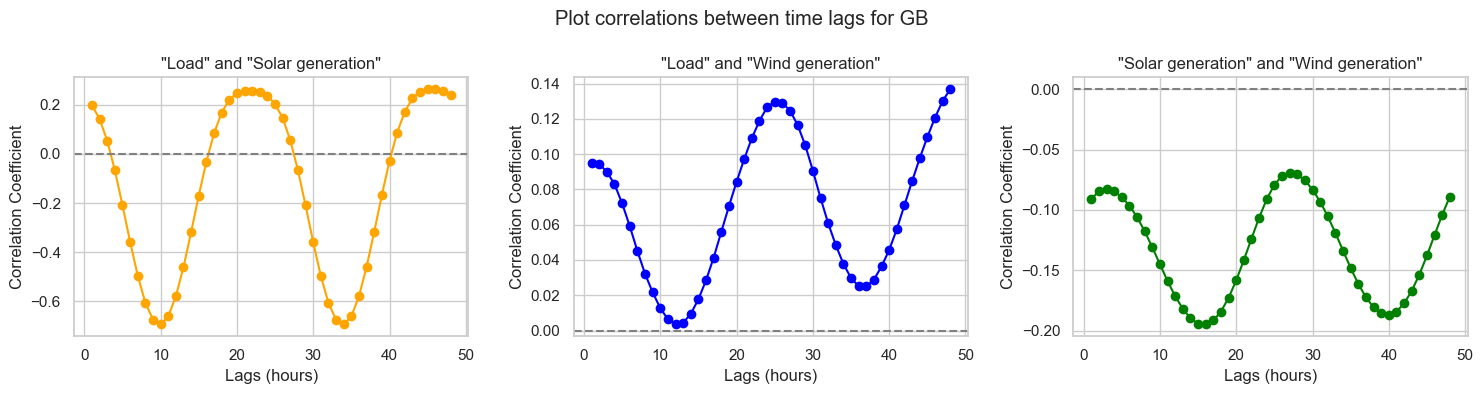

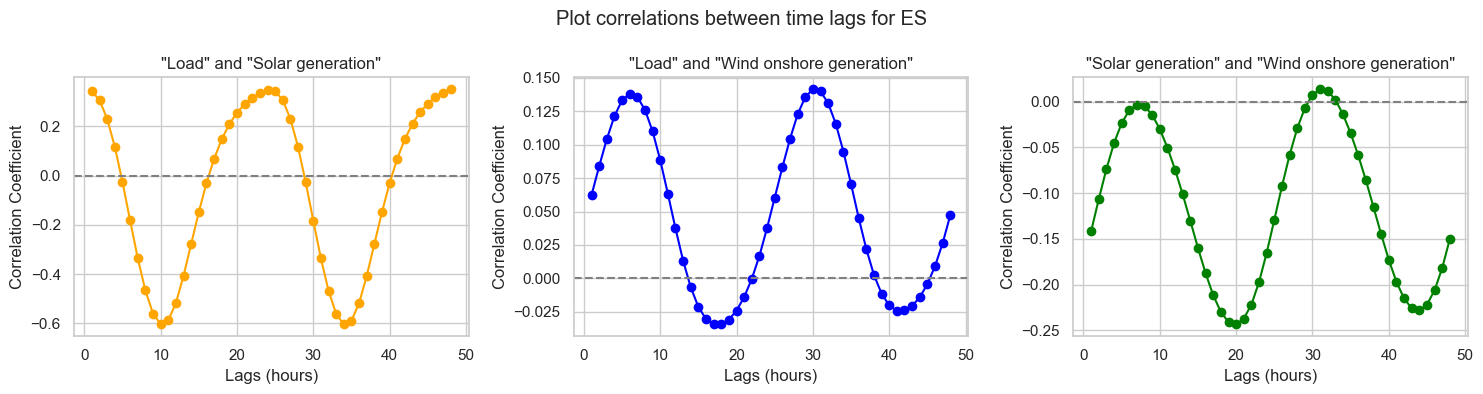

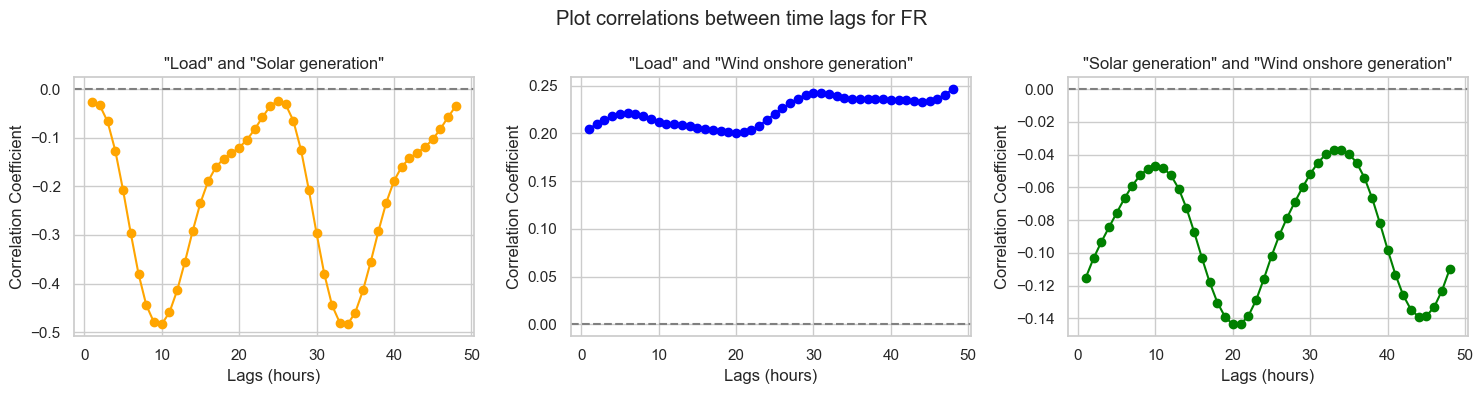

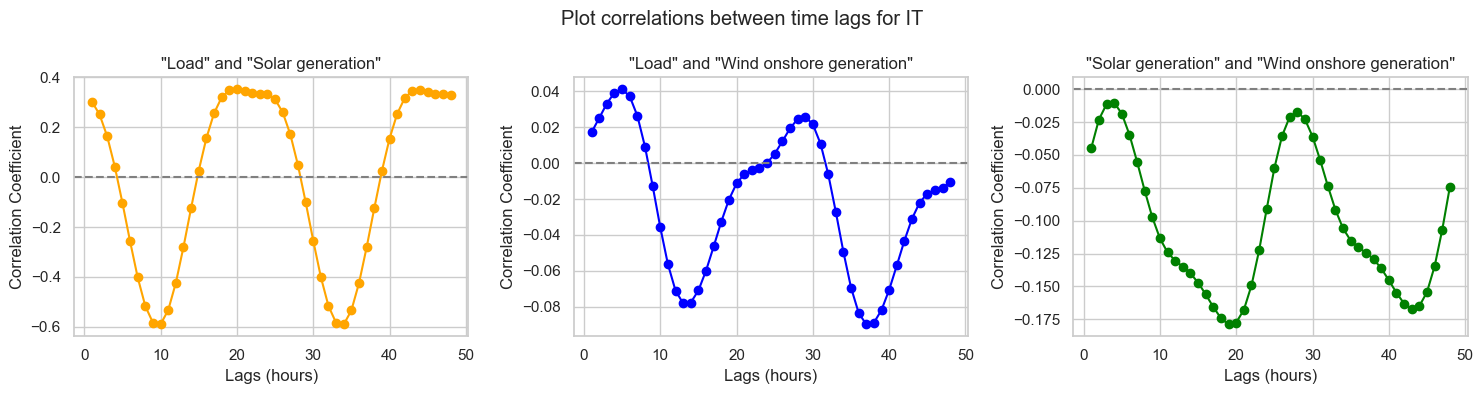

In [62]:
# This plot shows the correlations with time lags between two variables
# Time relationship

colors = ['orange', 'blue', 'green']

for country in top_5_countries:
    fig, axs = plt.subplots(1, 3, figsize=(15, 4))  
    
    data = df_top_5.filter(like=country, axis=1)  
    
    for idx, (col1, col2) in enumerate(combinations(data.columns[:3], 2)):  # Generate combinations of 2 columns
        plot_correlations_between_2vars(data, col1, col2, axs[idx], colors[idx])  # Plot each combination
    
    plt.suptitle(f'Plot correlations with time lags for {country}')
    plt.tight_layout()  
    plt.show()  


# 8. Test for stationarity

The following section checks our data in pursuit of stationarity and interrelationships between variables. 
First we determine each time serie for stationarity, namely does it require trend or seasonal differencing.
Then, we apply Granger causality test to find whether one time serie past values are beneficial to predict another.

We performed tests, like Augmented Dickey-Fuller (ADF) and Kwiatkowski-Phillips-Schmidt-Shin (KPSS), to check for trend stationarity. And OCSB and CHTest for seasonality. As we can see, all series exhibit non-stationarity. Most wind-related series do not have seasonality. We decided on use of the pmdarima package, because of its functionality. The combination of tests is preferred due to package description (statsmodel package advises the same).

In [47]:
seas = list()

for col_name in df_top_5.select_dtypes(include='float').columns:
    seasonal = stationary_seasonal(df_top_5, col_name)
    seas.append(seasonal) if seasonal is not None else None

Column name: DE_load_actual_entsoe_transparency
ADF: Is stationary.
KPSS: Is not stationary.
kpss_diff 1
Requires seasonal differencing
ocsb_diff 0 ch_diff 1
--------------------------------------------------
Column name: DE_solar_generation_actual
ADF: Is stationary.
KPSS: Is not stationary.
kpss_diff 1
Requires seasonal differencing
ocsb_diff 0 ch_diff 1
--------------------------------------------------
Column name: DE_wind_generation_actual
ADF: Is stationary.
KPSS: Is not stationary.
kpss_diff 1
Does not require seasonal differencing
--------------------------------------------------
Column name: DE_wind_offshore_generation_actual
ADF: Is stationary.
KPSS: Is not stationary.
kpss_diff 1
Does not require seasonal differencing
--------------------------------------------------
Column name: DE_wind_onshore_generation_actual
ADF: Is stationary.
KPSS: Is not stationary.
kpss_diff 1
Does not require seasonal differencing
--------------------------------------------------
Column name: ES

In [48]:
# Columns that are not stationary 
seas

['DE_load_actual_entsoe_transparency',
 'DE_solar_generation_actual',
 'ES_load_actual_entsoe_transparency',
 'ES_solar_generation_actual',
 'FR_load_actual_entsoe_transparency',
 'FR_solar_generation_actual',
 'GB_UKM_load_actual_entsoe_transparency',
 'GB_UKM_solar_generation_actual',
 'GB_UKM_wind_generation_actual',
 'GB_UKM_wind_offshore_generation_actual',
 'GB_UKM_wind_onshore_generation_actual',
 'IT_load_actual_entsoe_transparency',
 'IT_solar_generation_actual',
 'IT_wind_onshore_generation_actual']